In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
import math
import re
import ast
import json
import plotly.express as px
import plotly.graph_objects as go
import plotly.io as pio
import pycountry_convert as pc
#NLP libraries
import spacy, nltk, gensim, sklearn
import pyLDAvis.gensim_models
import warnings; warnings.simplefilter('ignore')
import os, codecs, string, random
#Vader
import vaderSentiment
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
from sklearn.preprocessing import MultiLabelBinarizer
from statsmodels.stats import diagnostic
from scipy import stats
from empath import Empath
#Scikit imports
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import r2_score
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.utils import shuffle
from statsmodels.stats import diagnostic
from scipy import stats
from scipy.stats import ttest_ind
from scipy.stats import chi2_contingency
from ipywidgets import interact, Dropdown
import category_encoders as ce

# Load Data

All data have been merged in Data_merge.ipynb and cleaned in cleaning_data.ipynb

In [ ]:
data_path = './data/preprocessed_datasets/'
original_data = './data/original_datasets/'
figure_path = './figures/'
data_character = pd.read_csv(data_path + 'clean_data_character.csv')
data_original = pd.read_csv(data_path + 'clean_data_original.csv')
ethnicity_df = pd.read_csv(data_path + 'ethnicity_labels.csv')
data_success = pd.read_csv(data_path + 'clean_data_success.csv')
tropes = pd.read_csv(original_data + 'CMU_dataset/tvtropes.clusters.txt', sep='\t', header=None, names=['trope', 'data'], engine='python')
all_metrics = pd.read_csv(data_path+'all_metrics.csv')
df_bechdel = pd.read_csv(data_path + 'bechdel.csv')

# Extract the values inside the second set of quotes for each key-value pair
def extract_values(_str):
    return re.findall(r': "([^"]+)"', _str)

# Apply the extraction function to the relevant columns
data_success['Languages'] = data_success['Languages'].apply(extract_values)
data_success['Countries'] = data_success['Countries'].apply(extract_values)
data_success['Genres'] = data_success['Genres'].apply(extract_values)

all_metrics['Languages'] = all_metrics['Languages'].apply(extract_values)
all_metrics['Countries'] = all_metrics['Countries'].apply(extract_values)
all_metrics['Genres'] = all_metrics['Genres'].apply(extract_values)

# Representation of Male and Female Actors

In [7]:
data_character_female = data_character[data_character["actor_gender"] == "F"]
data_character_male = data_character[data_character["actor_gender"] == "M"]
nbre_female = len(data_character_female)
nbre_male = len(data_character_male)
nbre_actors = nbre_male + nbre_female

In [8]:

# Data Preparation
percent_female = (nbre_female / nbre_actors) * 100
percent_male = (nbre_male / nbre_actors) * 100
total_icons = 100
male_icons = int(total_icons * (percent_male / 100))
female_icons = total_icons - male_icons
# Generate grid positions
grid_size = 10
x_positions = np.tile(np.arange(grid_size), grid_size)
y_positions = np.repeat(np.arange(grid_size), grid_size)
# Create gender labels for each icon
gender_labels = ['Female'] * female_icons + ['Male'] * male_icons
# Create color mapping for icons
color_map = {'Female': '#ff4f41', 'Male': '#4ea2dd'}
marker_colors = [color_map[gender] for gender in gender_labels]
# Create scatter plot for icons
fig = go.Figure(go.Scatter(
    x=x_positions[:total_icons],
    y=-y_positions[:total_icons],
    mode='markers',
    marker=dict(size=20, color=marker_colors, symbol='circle'),
    hoverinfo='text',
    hovertext=[f"{gender}: {percent_female:.1f}%" if gender == 'Female' else f"{gender}: {percent_male:.1f}%" for gender in gender_labels]
))

# Update layout for better appearance
fig.update_layout(
    title_text="Gender distribution in cinema",
    title_font=dict(size=24, color='#2c3e50'),
    title_x=0.53,
    title_y=0.95,
    xaxis=dict(visible=False),
    yaxis=dict(visible=False),
    plot_bgcolor='white',
    height=400,  # Reduced height
    width=400,   # Reduced width
    margin=dict(t=30, b=20, l=10, r=10),  # Adjusted margins
    showlegend=False
)
# Add percentage annotations
fig.add_annotation(
    x=-1,
    y=-11.5,
    text=f"<b>{percent_female:.1f}%</b>",
    showarrow=False,
    font=dict(size=30, color='#ff4f41')
)

fig.add_annotation(
    x=9,
    y=-11.5,
    text=f"<b>{percent_male:.1f}%</b>",
    showarrow=False,
    font=dict(size=30, color='#4ea2dd')
)

# Add custom icons for gender labels
fig.add_layout_image(
    dict(
        source="https://img.icons8.com/?size=100&id=21829&format=png&color=ff4f41",
        xref="paper", yref="paper",
        x=0.4, y=0.05,
        xanchor="center", yanchor="middle",
        sizex=0.15, sizey=0.15,
        layer="above"
    )
)

fig.add_layout_image(
    dict(
        source="https://img.icons8.com/?size=100&id=21830&format=png&color=4ea2dd",
        xref="paper", yref="paper",
        x=0.6, y=0.05,
        xanchor="center", yanchor="middle",
        sizex=0.15, sizey=0.15,
        layer="above"
    )
)

# Show the figure
fig.show()

# Save the figure as an HTML file to your GitHub website's 'assets' folder
output_path = figure_path +"gender_distribution.html"
pio.write_html(fig, output_path)



As expected, a significant difference is observed in the number of actors between men and women. Here, men represent 66.18% of the actors, while women account for 33.82%.  
Now, the question is: even if women have always been underrepresented in cinema since its inception, has their representation increased over the years?

In [ ]:
data_original['num_actors'] = data_original['Movie_ID'].map(data_character.groupby('Movie_ID')['Actor_ID'].nunique())
data_original['num_women'] = data_original['Movie_ID'].map(data_character[data_character['actor_gender']=='F'].groupby('Movie_ID')['Actor_ID'].nunique())
data_original['proportion_actress'] = data_original['num_women']/data_original['num_actors']
data_original_croped = data_original.dropna(subset=['proportion_actress'])

#remove movies with less than 4 actors informations
data_original_croped = data_original_croped[data_original_croped['num_actors'] >= 4]

proportion_actress_year = data_original_croped.groupby('Year').agg(
    proportion_actress=('proportion_actress', 'mean'),
    num_actors=('num_actors', 'mean'),
    um_actresses=('num_women', 'mean'),
    sample_count=('Year', 'size')
).reset_index()

movies_by_year = proportion_actress_year[proportion_actress_year['sample_count'] >= 200]


fig = px.line(
    movies_by_year, 
    x='Year', 
    y='proportion_actress', 
    title='Evolution of Actress Proportion by Year',
    labels={
        'Year': 'Year',
        'proportion_actress': 'Proportion of Actresses',
    },
    markers=True
)

fig.update_layout(
    xaxis_title="Year",
    yaxis_title="Mean Proportion of Actresses",
    template="plotly_white"
)

fig.show()

output_path_3 = figure_path + "actress_prop_years.html"
pio.write_html(fig, output_path_3)


Given that the number of films per year is not consistent in our data and we might be missing some actors informations, to study the evolution of the number of actors over the years, we decided to look at the evolution of the proportion of actress rather than the number of female actress. There does not seem to be a correlation between the year and the proportion of female actress in movies.  To ensure a more accurate and fair analysis, we limit our focus to years with a minimum of 100 movies. In addiction we removed movies with less than 4 actors in our dataset

Looking at the evolution of the proportion of actress, there seems be a very low correlation between the year and the proportion of actress. There is no evident improvement of female representation in recent movies.

Pearson correlation has a coefficient of 0.491 which is higly significant with a p-value of 3.87e-05.
Spearman correlation has a coefficient of 0.463 which is higly significant with a p-value of 0.000116.


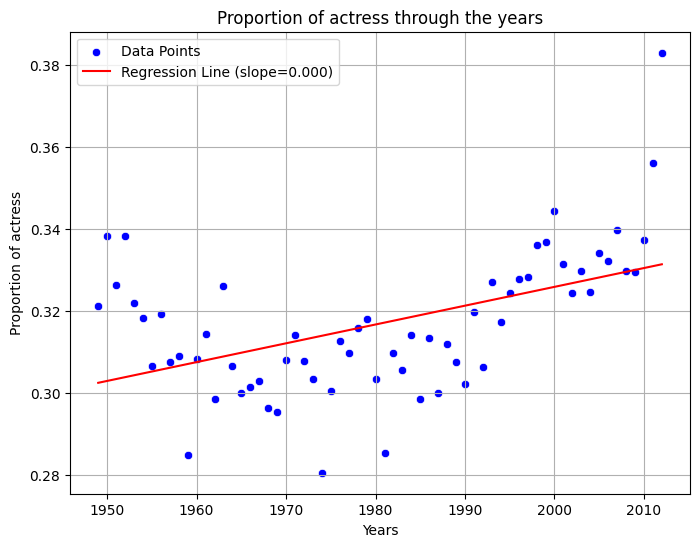

In [ ]:
from scipy.stats import linregress
x = movies_by_year['Year']
y = movies_by_year['proportion_actress']

slope, intercept, r_value, p_value, std_err = linregress(x, y)
regression_line = slope * x + intercept

pearson = stats.pearsonr(x, y)
print(f"Pearson correlation has a coefficient of {pearson[0]:.3} which is higly significant with a p-value of {pearson[1]:.3}.")

spearman = stats.spearmanr(x, y)
print(f"Spearman correlation has a coefficient of {spearman[0]:.3} which is higly significant with a p-value of {spearman[1]:.3}.")

plt.figure(figsize=(8, 6))
sns.scatterplot(x=x, y=y, color='blue', label='Data Points')
plt.plot(x, regression_line, color='red', label=f'Regression Line (slope={slope:.3f})')
plt.title('Proportion of actress through the years')
plt.xlabel('Years')
plt.ylabel('Proportion of actress')
plt.legend()
plt.grid(True)
plt.show()

The proportion of actresses in movies shows a moderate positive trend over the years, with a Pearson correlation of 0.491 (p-value = 3.87e-05) and a Spearman correlation of 0.463 (p-value = 0.000116). This indicates a consistent and statistically significant increase in actress representation over time. However the improvement is very slow and the proportion of actress remains under 0.5.

Women remain underrepresented in cinema, a reality that has inspired various movements to promote gender equality in the industry. 

Another initiative is the Bechdel Test, introduced by Alison Bechdel in 1985. This simple yet powerful tool measures representation by requiring that a film include at least two women who talk to each other about something other than a man. While not comprehensive, the test highlights the widespread lack of meaningful roles for women and has become a key benchmark in discussions about gender equity in cinema.

There is, however, hope for change. Movements like Me Too and Time’s Up have raised awareness and advocated for greater inclusivity in storytelling and casting. Although the male-to-female ratio in the industry has not shifted dramatically, the absolute number of women working in cinema has grown, reflecting slow but steady progress.


#### Load the data for the semantic analysis of the synopsis
To decide wether a movie has a female lead we decided to focus on the synopsis and see weither the majory of word are more female categorized or not

In [11]:
summary = pd.read_csv(original_data + 'CMU_dataset/plot_summaries.txt',sep='\t',header=None, names=['Wiki_ID', 'summary'], encoding='utf-8', on_bad_lines='skip')

summary['Wiki_ID'] = summary['Wiki_ID'].astype(str)
all_metrics['Wiki_ID'] = all_metrics['Wiki_ID'].astype(str)
data = summary.merge(all_metrics[['Wiki_ID', 'incl_score']], on='Wiki_ID')

Preprocess the Text with Spacy

In [14]:
nlp = spacy.load("en_core_web_sm")
# Function to preprocess text
def preprocess(text):
    doc = nlp(text)
    tokens = [token.lemma_ for token in doc if token.is_alpha and not token.is_stop]
    return " ".join(tokens)

# Apply preprocessing to each summary
data['clean_summary'] = data['summary'].apply(preprocess)

Fonction to identify if the synopsis gendered.

In [15]:
def gendered_context(text):
    doc = nlp(text)
    female_terms = {"she", "her", "woman", "girl", "mother", "wife"}
    male_terms = {"he", "him", "man", "boy", "father", "husband"}

    female_count = sum(1 for token in doc if token.text.lower() in female_terms)
    male_count = sum(1 for token in doc if token.text.lower() in male_terms)

    if female_count > male_count:
        return "female"
    elif male_count > female_count:
        return "male"
    else:
        return "neutral"

In [16]:
data['gender_context'] = data['clean_summary'].apply(gendered_context)
# Count occurrences of each gender context
gender_counts = data['gender_context'].value_counts()

Analysis of Female Protagonists in the Top 15 Movie Genres

In [18]:
# Convert 'Wiki_ID' in both DataFrames to string type
data['Wiki_ID'] = data['Wiki_ID'].astype(str)
data_success['Wiki_ID'] = data_success['Wiki_ID'].astype(str)

# Merge gender context with data_success to get genres
data_with_genres = pd.merge(data[['Wiki_ID', 'gender_context']], data_success[['Wiki_ID', 'Genres']], on='Wiki_ID', how='inner')

# Explode genres for analysis
data_with_genres['Genres'] = data_with_genres['Genres'].apply(lambda x: eval(x) if isinstance(x, str) else x)
data_exploded = data_with_genres.explode('Genres')

# Count total movies per genre
total_movies_by_genre = data_exploded['Genres'].value_counts()

# Select the top 15 genres with the highest number of movies
top_15_genres = total_movies_by_genre.head(15).index

# Filter data to include only the top 15 genres
data_top_15 = data_exploded[data_exploded['Genres'].isin(top_15_genres)]

# Filter only female-led movies within the top 15 genres
female_led_movies = data_top_15[data_top_15['gender_context'] == 'female']

# Count female-led movies per genre within the top 15
female_count_by_genre = female_led_movies['Genres'].value_counts()

# Recalculate total movies per genre for the top 15
total_movies_by_genre_top_15 = data_top_15['Genres'].value_counts()

# Calculate the percentage of female-led movies per genre for the top 15
percentage_female_by_genre = (female_count_by_genre / total_movies_by_genre_top_15) * 100

# Drop NaN and sort values in descending order
percentage_female_by_genre = percentage_female_by_genre.dropna().sort_values(ascending=False)

# Create the interactive Plotly bar chart
fig = go.Figure()

fig.add_trace(go.Bar(
    x=percentage_female_by_genre.values,
    y=percentage_female_by_genre.index,
    orientation='h',
    marker=dict(color='#ff4f41', line=dict(color='rgba(231, 0, 0, 1)', width=1)),
    text=[f"{value:.1f}%" for value in percentage_female_by_genre.values],
    textposition='outside',
    hovertemplate='Genre: %{y}<br>Percentage: %{x:.2f}%<extra></extra>'
))
fig.update_layout(
    title=dict(
        text='Presence of female protagonists by top 15 movie genres',
        x=0.5,
        font=dict(size=20, color='#2c3e50')
    ),
    xaxis=dict(
        title='Percentage of movies with a female lead',
        showgrid=True,
        gridcolor='#eaeaea',
        range=[0, 100]
    ),
    yaxis=dict(
        title='Genre',
        showgrid=False,
        autorange='reversed' 
    ),
    plot_bgcolor='#eaeaea',
    paper_bgcolor='rgb(245,245,245)',
    margin=dict(t=80, b=60, l=100, r=60), 
    hovermode='y unified'
)
fig.show()
# Save the figure as an HTML file to your GitHub website's 'assets' folder
output_path_4 = figure_path + "pourcentage_women_by_genre.html"
pio.write_html(fig, output_path_4)



We were able to analyze the prevalence of female protagonists in the top 15 most frequent movie genres, revealing insightful patterns in gender representation across cinema. The results highlight significant variation among genres, reflecting both historical stereotypes and emerging trends in film narratives.

We found that Horror leads the way, with 40.3% of films featuring female protagonists. This aligns with the genre's well-known "final girl" trope, where a female character often survives and triumphs over the horror, symbolizing resilience and strength. This recurring narrative device has helped establish women as central figures in horror films.
In Romance Films, female leads account for 39.6% of protagonists. Given the genre's focus on relationships and emotional exploration, it's unsurprising that women's experiences are often at the forefront. We were also able to observe that Mystery films feature female leads in 36.2% of cases. This indicates a growing trend of women taking on roles as detectives, investigators, or central figures solving complex narratives. Their presence signals a move toward more dynamic and intellectually engaged female characters.We were able to identify that genres traditionally dominated by male protagonists, such as Adventure (22.6%), Action/Adventure (21.3%), and Action (20.6%), still show lower female representation. While these genres are starting to incorporate more female leads, they remain behind in terms of gender parity. Continued efforts are necessary to diversify these action-oriented narratives and better represent women's stories.
By recognizing these patterns,as a filmmakers you can take meaningful steps toward more balanced and inclusive storytelling.

Rather then depicting the real-life women, cinema tends to perpetuate negative gender stereotypes which are reflected in the roles women play in films.
Some of our hypothesis is that women often receive secondary ad stereotypical representation tied to traditional roles of wives, lovers, mothers....
We think also that they are portrayed as overly emotional or dramatic.
We will also try to identify the tropes that leading to the greteast success.


# Success metric

To determine what a successfull movie is, we need to establish a success metric for the analysis, we considered two key factors:  
1. **Financial performance** – what the movie gained in terms of money.  
2. **Audience reception** – how much people liked the movie based on its IMDb rating.

However, box office revenue alone accounts for total earnings but does not consider the production budget, leading to potentially biased evaluations. For instance:  
- A low-budget film generating three times its cost could be highly profitable yet appear less successful in absolute revenue terms compared to a high-budget blockbuster.

To address this bias, we introduced **Net Box Office Revenue** (`Net_revenue`), defined as:  


$$
\textbf{Net Box Office Revenue} = \text{Box Office Revenue} - \text{Initial Budget}
$$


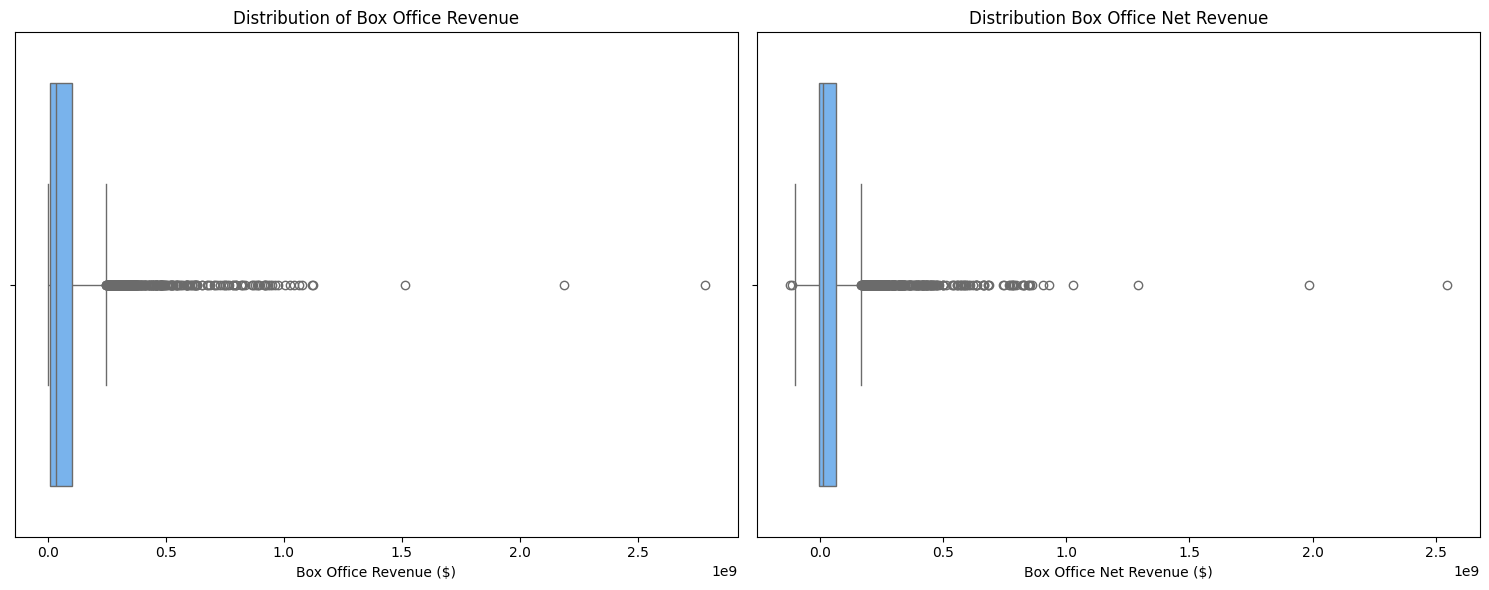

In [19]:
fig, axes = plt.subplots(1, 2, figsize=(15, 6))

# First subplot for Box Office Revenue
sns.boxplot(data=data_success, x='BoxOfficeRevenue', color='#66b3ff', ax=axes[0])
axes[0].set_title("Distribution of Box Office Revenue")
axes[0].set_xlabel("Box Office Revenue ($)")

# Second subplot for Net Box Office Revenue
sns.boxplot(data=data_success, x='Net_revenue', color='#66b3ff', ax=axes[1])
axes[1].set_title("Distribution Box Office Net Revenue")
axes[1].set_xlabel("Box Office Net Revenue ($)")

plt.tight_layout()
plt.show()

This adjustment provides a more balanced distribution of financial performance within the metrics, offering a clearer representation of profitability and a fairer comparison across films.

Since movie ranking is a grade out of ten and revenue can be in billions of dollars we will need to normalize these metrics. Using rank normalization to combine box-office net revenue and IMDb ratings ensures a fair and balanced comparison between these two metrics, despite their differences in scale and distribution. By converting raw values into ranks, this approach eliminates the influence of large numerical disparities and focuses on the relative performance within each dataset. This is particularly important since revenue is skewed by a few blockbusters while ratings tend to be more evenly distributed. The result is a unified metric that captures both financial success and audience approval without bias, enabling a comprehensive and equitable evaluation.


$$
\textbf{Success Metric} = a_1 \cdot \text{rank}(\text{Net Box Office Revenue}) + a_2 \cdot \text{rank}(\text{Rating})
$$

To determine the appropriate weights a<sub>1</sub> and a<sub>2</sub> for each metric when combining them, we can plot one against the other (e.g., box-office revenue vs. IMDb rating) to assess their correlation. If the correlation is weak or non-existent, it indicates that the two metrics measure different and independent aspects of success. In such a case, it would be reasonable to assign equal weights (0.5) to each metric, ensuring that neither dominates the combined metric. This approach ensures a balanced representation of both financial performance and audience approval in the final evaluation.

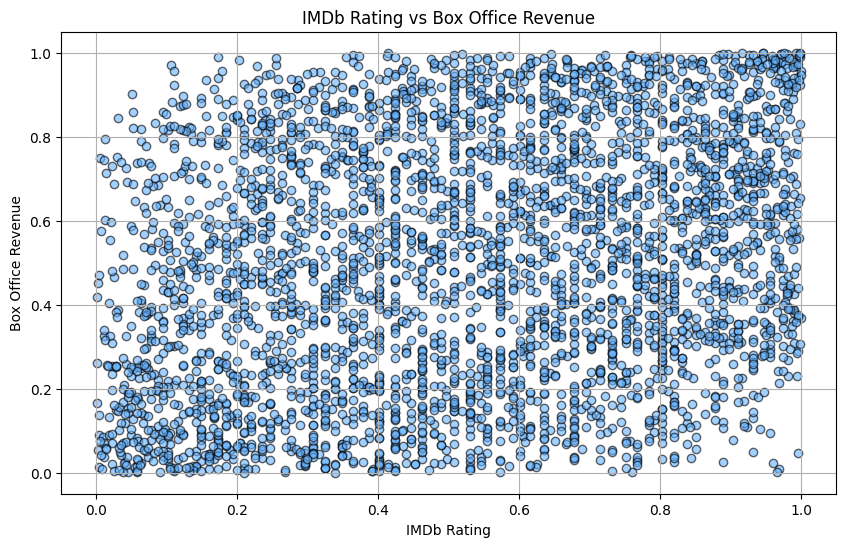

Pearson correlation has a coefficient of 0.273 which is higly significant with a p-value of 1.66e-62.
Spearman correlation has a coefficient of 0.271 which is higly significant with a p-value of 1.01e-61.


In [20]:
plt.figure(figsize=(10, 6))
plt.scatter(data_success['RatingRank'],data_success['BoxOfficeRank'],  alpha=0.6, color='#66b3ff', edgecolor='black')
plt.title("IMDb Rating vs Box Office Revenue")
plt.ylabel("Box Office Revenue")
plt.xlabel("IMDb Rating")
plt.grid(True)
plt.show()

data_successs_noNA = data_success.dropna(subset=['BoxOfficeRank', 'RatingRank'])
pearson = stats.pearsonr(data_successs_noNA['BoxOfficeRank'], data_successs_noNA['RatingRank'])
print(f"Pearson correlation has a coefficient of {pearson[0]:.3} which is higly significant with a p-value of {pearson[1]:.3}.")

spearman = stats.spearmanr(data_successs_noNA['BoxOfficeRank'], data_successs_noNA['RatingRank'])
print(f"Spearman correlation has a coefficient of {spearman[0]:.3} which is higly significant with a p-value of {spearman[1]:.3}.")

In [21]:
weight_box_office = 0.5
weight_imdb = 0.5
data_success['SuccessMetric'] = (weight_box_office * data_success['BoxOfficeRank']) + (weight_imdb * data_success['RatingRank'])

Now that we've defined our success metric, the next step is to examine the relationships and correlations between the various input variables and the success metric. This will help us understand which features are most important for making accurate predictions and guide us in selecting the right inputs for our predictive model.

# Proportion female actress correlation to success

In [22]:
data_success['num_actors'] = data_success['Movie_ID'].map(data_character.groupby('Movie_ID')['Actor_ID'].nunique())
data_success['num_women'] = data_success['Movie_ID'].map(data_character[data_character['actor_gender']=='F'].groupby('Movie_ID')['Actor_ID'].nunique())
data_success['proportion_actress'] = data_success['num_women']/data_success['num_actors']

data_success1 = data_success.copy()

In [23]:
data_success1_croped = data_success1.dropna(subset=['num_actors', 'num_women', 'SuccessMetric'])

proportion_actress_success = data_success1_croped.groupby('proportion_actress').agg(
    SuccessMetric=('SuccessMetric', 'mean'),
    sample_count=('Year', 'size')
).reset_index()

proportion_actress_success = proportion_actress_success[proportion_actress_success['sample_count'] >= 10]

Pearson correlation has a coefficient of -0.228 which is higly significant with a p-value of 0.0525.
Spearman correlation has a coefficient of -0.235 which is higly significant with a p-value of 0.045.


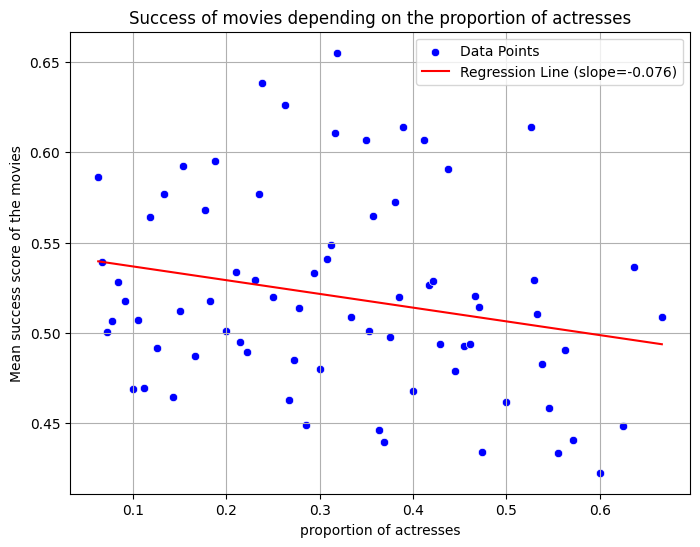

In [24]:
from scipy.stats import linregress
x = proportion_actress_success['proportion_actress']
y = proportion_actress_success['SuccessMetric']

slope, intercept, r_value, p_value, std_err = linregress(x, y)
regression_line = slope * x + intercept

pearson = stats.pearsonr(x, y)
print(f"Pearson correlation has a coefficient of {pearson[0]:.3} which is higly significant with a p-value of {pearson[1]:.3}.")

spearman = stats.spearmanr(x, y)
print(f"Spearman correlation has a coefficient of {spearman[0]:.3} which is higly significant with a p-value of {spearman[1]:.3}.")

# Plot the scatter plot and regression line
plt.figure(figsize=(8, 6))
sns.scatterplot(x=x, y=y, color='blue', label='Data Points')
plt.plot(x, regression_line, color='red', label=f'Regression Line (slope={slope:.3f})')
plt.title('Success of movies depending on the proportion of actresses')
plt.xlabel('proportion of actresses')
plt.ylabel('Mean success score of the movies')
plt.legend()
plt.grid(True)
plt.show()

Unfortunately the proportion of actresses shows a weak negative correlation with movie success, with a Pearson coefficient of -0.228 (p-value = 0.0525) and a Spearman coefficient of -0.235 (p-value = 0.045). However, this result should be interpreted with caution, as the weak correlation suggests limited practical significance, and the p-value for Pearson is very close to 0.05 which indicates ow statistical significance.

# Ethnicity correlation

Create a numerical categorical variable associated with the different ethnicities

In [25]:
ethnicity_df['ethnic_cat'] = ethnicity_df.index
data_character = pd.merge(data_character, ethnicity_df[['ethnicity_ID', 'ethnic_cat']], on='ethnicity_ID', how='left')
women_data = data_character[data_character['actor_gender']=='F'].copy()
men_data = data_character[data_character['actor_gender']=='M'].copy()

We will only consider the ethnicities for which we have a minimum of 30 different actors. Else, it doesn't seem to be enough to draw any conclusions.

In [26]:
low_count_ethnicities = ethnicity_df.loc[ethnicity_df['count'] < 30, 'ethnic_cat'].tolist()
women_data_ethnicity = women_data.copy()
women_data_ethnicity['ethnic_cat'] = women_data['ethnic_cat'].apply(lambda x: pd.NA if x in low_count_ethnicities else x)
men_data_ethnicity = men_data.copy()
men_data_ethnicity['ethnic_cat'] = men_data['ethnic_cat'].apply(lambda x: pd.NA if x in low_count_ethnicities else x)

We will keep only movies with at least 4 actors and 10% actress since we are focusing on actress.

In [27]:
valid_mask = (data_success['proportion_actress'] >= 0.1) & (data_success['num_actors'] > 4)
movies_women = data_success[valid_mask].copy()

valid_mask = (data_success['proportion_actress'] <= 0.9) & (data_success['num_actors'] > 4)
movies_men = data_success[valid_mask].copy()

In [28]:
def merge_and_group_data(women_data, movies_data, valid_ethnicity_threshold=30):
    # Merge the datasets
    analysis = pd.merge(
        women_data[['actor_age_movie_released', 'Movie_ID', 'actor_name', 'ethnic_cat', 'actor_height']],
        movies_data.dropna(subset=['SuccessMetric'])[['title', 'SuccessMetric', 'Movie_ID', 'proportion_actress', 'rating']],
        on='Movie_ID',
        how='inner'
    )

    # Group data and calculate statistics
    grouped_data = analysis.groupby('Movie_ID').agg(
        mean_age=('actor_age_movie_released', 'median'),
        num_women=('actor_age_movie_released', 'size'),
        title=('title', 'first'),
        SuccessMetric=('SuccessMetric', 'first'),
        proportion_actress=('proportion_actress', 'first'),
        ethnicities=('ethnic_cat', lambda x: [eth for eth in x if pd.notna(eth)]),
        avg_height=('actor_height', 'mean'),
        Rating=('rating', 'first')
    ).reset_index()

    # Filter ethnicities by occurrence threshold
    ethnicity_counts = pd.Series([eth for sublist in grouped_data['ethnicities'] for eth in sublist if pd.notna(eth)]).value_counts()
    valid_ethnicities = ethnicity_counts[ethnicity_counts >= valid_ethnicity_threshold].index

    grouped_data['ethnicities'] = grouped_data['ethnicities'].apply(
        lambda eth_list: [eth for eth in eth_list if eth in valid_ethnicities]
    )

    return grouped_data[grouped_data['ethnicities'].apply(len) > 0]


mean_women_data_ethnicity = merge_and_group_data(women_data_ethnicity, movies_women)

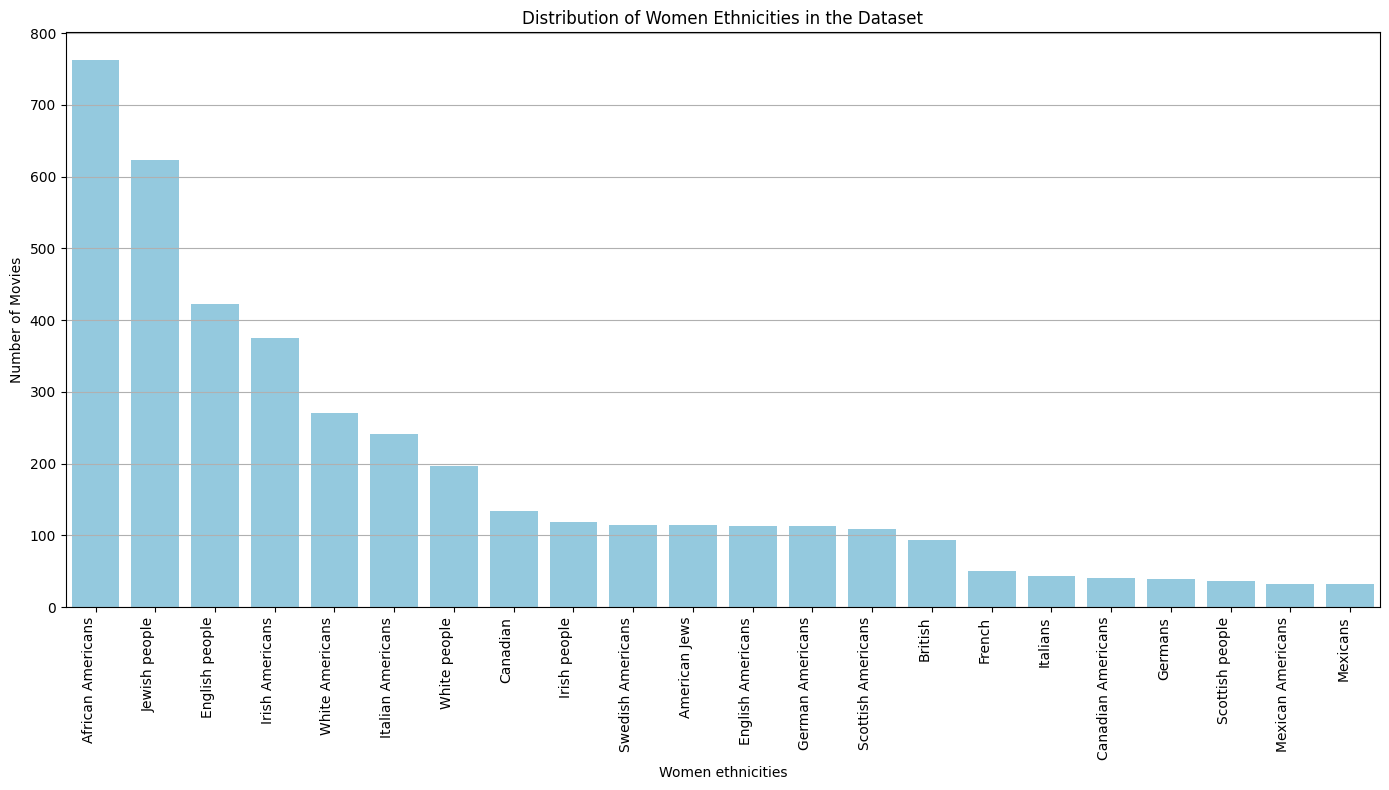

In [29]:
def plot_ethnicity_distribution(data, ethnicity_df):
    ethnicity_counts = pd.Series([eth for sublist in data['ethnicities'] for eth in sublist if pd.notna(eth)])
    ethnicity_distribution = ethnicity_counts.value_counts().reset_index()
    ethnicity_distribution.columns = ['ethnic_cat', 'count']

    ethnicity_distribution = pd.merge(
        ethnicity_distribution,
        ethnicity_df[['ethnic_cat', 'ethnicity_label']],
        on='ethnic_cat',
        how='left'
    ).sort_values(by='count', ascending=False)

    plt.figure(figsize=(14, 8))
    sns.barplot(x='ethnicity_label', y='count', data=ethnicity_distribution, color='skyblue')
    plt.title("Distribution of Women Ethnicities in the Dataset")
    plt.xlabel("Women ethnicities")
    plt.ylabel("Number of Movies")
    plt.xticks(rotation=90, ha='right')
    plt.grid(axis='y')
    plt.tight_layout()
    plt.show()
    
plot_ethnicity_distribution(mean_women_data_ethnicity, ethnicity_df)

The distribution of the data on the different ethnicities is not equally distributed at all. We will have to be carefull with this.

We looked at the difference of mean success metrics between movies containing at least one actress from an ethnicity compared to all other movies. Then we performed a t-test using equal_var=False to compensate the fact that the distribution is not even for every ethnicity.

In [30]:
import plotly.express as px
from ipywidgets import widgets, interact, Dropdown
from IPython.display import display, clear_output

def analyze_success_by_ethnicity(data, ethnicity_df, gender):
    results_list = []
    all_ethnic_cats = pd.Series([eth for sublist in data['ethnicities'] for eth in sublist if pd.notna(eth)]).unique()

    for ethnic_cat in all_ethnic_cats:
        movies_with = data[data['ethnicities'].apply(lambda x: isinstance(x, list) and ethnic_cat in x)]
        movies_without = data[data['ethnicities'].apply(lambda x: isinstance(x, list) and ethnic_cat not in x)]

        if len(movies_with) < 20 or len(movies_without) < 20:
            continue

        mean_with = movies_with['SuccessMetric'].mean()
        mean_without = movies_without['SuccessMetric'].mean()

        if movies_with['SuccessMetric'].nunique() < 2 or movies_without['SuccessMetric'].nunique() < 2:
            t_stat, p_value = np.nan, np.nan
        else:
            t_stat, p_value = ttest_ind(
                movies_with['SuccessMetric'].dropna(),
                movies_without['SuccessMetric'].dropna(),
                equal_var=False
            )

        results_list.append({
            'ethnic_cat': ethnic_cat,
            'nb_movies_with': len(movies_with),
            'nb_movies_without': len(movies_without),
            'mean_diff': mean_with - mean_without,
            'mean_with_ethnic_cat': mean_with,
            'mean_without_ethnic_cat': mean_without,
            't_stat': t_stat,
            'p_value': p_value
        })

    results_df = pd.DataFrame(results_list).sort_values(by='p_value').head(10)  # Keep only top 10 ethnicities by p-value
    merged_df = pd.merge(results_df, ethnicity_df[['ethnic_cat', 'ethnicity_label']], on='ethnic_cat', how='left')
    merged_df_clean = merged_df.dropna(subset=['p_value'])
    merged_df_clean['Significant'] = merged_df_clean['p_value'] < 0.05

    fig = px.bar(
        merged_df_clean,
        x='ethnicity_label',
        y='mean_diff',
        color='Significant',
        color_discrete_map={True: 'red', False: 'gray'},
        title=f"Mean Difference in Success Metric by Ethnicity ({gender})",
        labels={"ethnicity_label": "Ethnicity", "mean_diff": "Mean Difference in Success Metric"}
    )
    fig.update_layout(
        xaxis_title="Ethnicity",
        yaxis_title="Mean Difference in Success Metric",
        xaxis_tickangle=45
    )
    return fig

def interactive_ethnicity_analysis():
    output_area = widgets.Output()
    display(output_area)

    def update_analysis(gender):
        data = mean_women_data_ethnicity if gender == 'Women' else mean_men_data_ethnicity
        with output_area:
            output_area.clear_output(wait=True)
            fig = analyze_success_by_ethnicity(data, ethnicity_df, gender)
            fig.show()

    interact(
        update_analysis,
        gender=Dropdown(options=[('Women', 'Women'), ('Men', 'Men')], value='Women', description='Gender')
    )

interactive_ethnicity_analysis()

Output()

interactive(children=(Dropdown(description='Gender', options=(('Women', 'Women'), ('Men', 'Men')), value='Wome…

# Investigating correlation between Actress' Age and Movie's success metrics

First, let's try to see if there seem to be any link between the actress's age and the Movie Success Score with only looking at the scatter plot.

In [35]:
data_original_croped = data_original_croped[data_original_croped['num_actors'] >= 4]
analysis = pd.merge(
        women_data[['actor_age_movie_released', 'Movie_ID', 'actor_name', 'ethnic_cat', 'actor_height']],
        movies_women.dropna(subset=['SuccessMetric'])[['title', 'SuccessMetric', 'Movie_ID', 'proportion_actress', 'rating']],
        on='Movie_ID',
        how='inner'
    )

actor_age_success = analysis.groupby('actor_age_movie_released').agg(
    rating=('rating', 'mean'),
    SuccessMetric=('SuccessMetric', 'mean'),
    sample_count=('actor_age_movie_released', 'size')
).reset_index()

actor_age_success = actor_age_success[actor_age_success['sample_count'] >= 4]

Pearson correlation has a coefficient of 0.0441 which is higly significant with a p-value of 0.692.
Spearman correlation has a coefficient of 0.0735 which is higly significant with a p-value of 0.509.


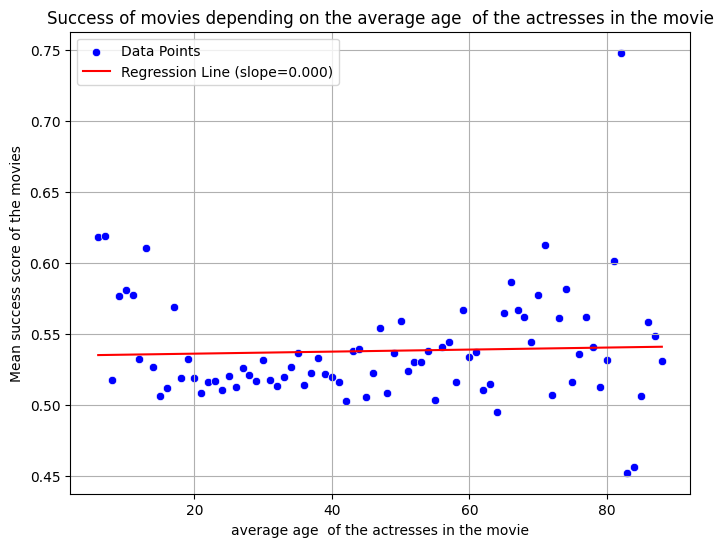

In [36]:
from scipy.stats import linregress
x = actor_age_success['actor_age_movie_released']
y = actor_age_success['SuccessMetric']

slope, intercept, r_value, p_value, std_err = linregress(x, y)
regression_line = slope * x + intercept

pearson = stats.pearsonr(x, y)
print(f"Pearson correlation has a coefficient of {pearson[0]:.3} which is higly significant with a p-value of {pearson[1]:.3}.")

spearman = stats.spearmanr(x, y)
print(f"Spearman correlation has a coefficient of {spearman[0]:.3} which is higly significant with a p-value of {spearman[1]:.3}.")

# Plot the scatter plot and regression line
plt.figure(figsize=(8, 6))
sns.scatterplot(x=x, y=y, color='blue', label='Data Points')
plt.plot(x, regression_line, color='red', label=f'Regression Line (slope={slope:.3f})')
plt.title('Success of movies depending on the average age  of the actresses in the movie')
plt.xlabel('average age  of the actresses in the movie')
plt.ylabel('Mean success score of the movies')
plt.legend()
plt.grid(True)
plt.show()

The correlation between actor age at movie release and movie success is very weak, with a Pearson coefficient of 0.102 (p-value = 0.375) and a Spearman coefficient of 0.114 (p-value = 0.32). Both correlations are not statistically significant, indicating no meaningful relationship between these variables. This suggests that actor age likely does not play a notable role in determining a movie's success, though further investigation with a larger or more balanced dataset might provide additional insights.

# Correlation between actress height and success of the movie

In [37]:
height_data = pd.merge(
        women_data[['actor_age_movie_released', 'Movie_ID', 'actor_name', 'ethnic_cat', 'actor_height']],
        data_success.dropna(subset=['SuccessMetric'])[['title', 'SuccessMetric', 'Movie_ID', 'proportion_actress', 'rating']],
        on='Movie_ID',
        how='inner'
    )

actor_height_success = height_data.groupby('actor_height').agg(
    rating=('rating', 'mean'),
    SuccessMetric=('SuccessMetric', 'mean'),
    sample_count=('actor_height', 'size')
).reset_index()

actor_height_success = actor_height_success[actor_height_success['sample_count'] >= 10]

Pearson correlation has a coefficient of -0.238 which is higly significant with a p-value of 0.0538.
Spearman correlation has a coefficient of -0.156 which is higly significant with a p-value of 0.212.


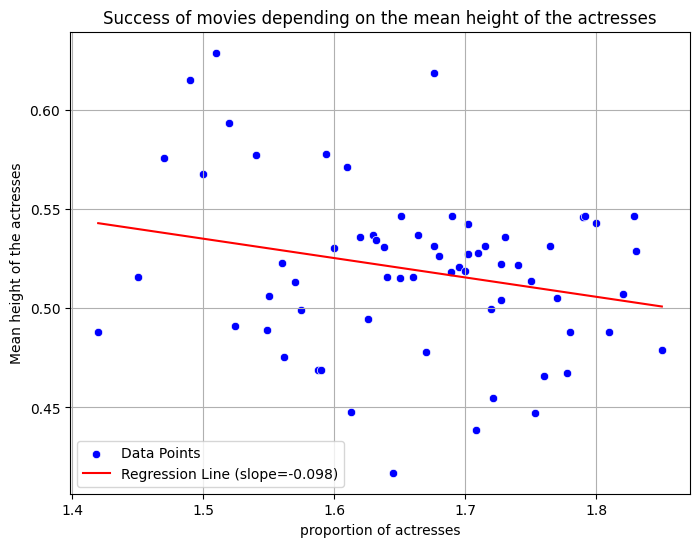

In [38]:
from scipy.stats import linregress
x = actor_height_success['actor_height']
y = actor_height_success['SuccessMetric']

slope, intercept, r_value, p_value, std_err = linregress(x, y)
regression_line = slope * x + intercept

pearson = stats.pearsonr(x, y)
print(f"Pearson correlation has a coefficient of {pearson[0]:.3} which is higly significant with a p-value of {pearson[1]:.3}.")

spearman = stats.spearmanr(x, y)
print(f"Spearman correlation has a coefficient of {spearman[0]:.3} which is higly significant with a p-value of {spearman[1]:.3}.")

# Plot the scatter plot and regression line
plt.figure(figsize=(8, 6))
sns.scatterplot(x=x, y=y, color='blue', label='Data Points')
plt.plot(x, regression_line, color='red', label=f'Regression Line (slope={slope:.3f})')
plt.title('Success of movies depending on the mean height of the actresses')
plt.xlabel('proportion of actresses')
plt.ylabel('Mean height of the actresses')
plt.legend()
plt.grid(True)
plt.show()

The analysis shows a weak negative relationship between actress height and movie success. The Pearson correlation is -0.238 with a p-value of 0.0538, indicating a trend that is close to, but not conventionally, statistically significant. The Spearman correlation is weaker at -0.156 with a p-value of 0.212, suggesting no significant monotonic relationship. These results imply limited evidence of a meaningful connection between actress mean height in the cast and the success of the movie.

# The Bechdel test

The Bechdel Test, or Bechdel-Wallace Test, sometimes called the Mo Movie Measure or Bechdel Rule is a simple test 
 which names the following three criteria: \
 1. it has to have at least two women in it, who \
 2. who talk to each other, about \
 3. something besides a man.

The test serves as a lens to evaluate whether a film provides meaningful interaction between female characters, reflecting broader trends in the portrayal of women in the film industry.

In this analysis, we will explore how Bechdel Test results have evolved over the years and across different regions of the world. We will also investigate how these scores relate to other aspects of films, such as revenue, ratings, and the presence of female lead actors.

By examining these relationships, our goal is to understand whether the representation of women in cinema has improved over time and whether films that perform well on the Bechdel Test are correlated with greater success. We aim to validate the theory that female representation is becoming more significant in the industry, potentially influencing a film's reception and success.

In the databased used, we only selected the years where there are at least 10 films in the original database.

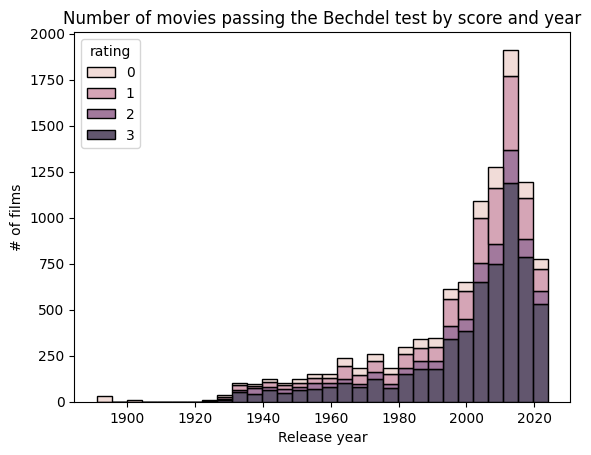

In [39]:
#Plotting the number of movies passing the Bechdel test by year and by score

sns.histplot(data=df_bechdel, x='year', hue='rating',multiple='stack',bins=30)

plt.title('Number of movies passing the Bechdel test by score and year')
plt.xlabel('Release year')
plt.ylabel('# of films');




By looking at the graph, we can suppose that indeed we now have many more films passing the Bechdel test than failing it.

However, it's still uncertain whether the proportion of films meeting these criteria has genuinely improved over time. To investigate this further, we will analyze the correlation between release years and the average Bechdel Test scores. Additionally, we will visualize the trend by plotting the average scores by year, supplemented with a linear regression line to highlight any patterns.

Pearson Correlation Coefficient: 0.6415, p-value: 4.896996829119613e-13, intercept=-15.79


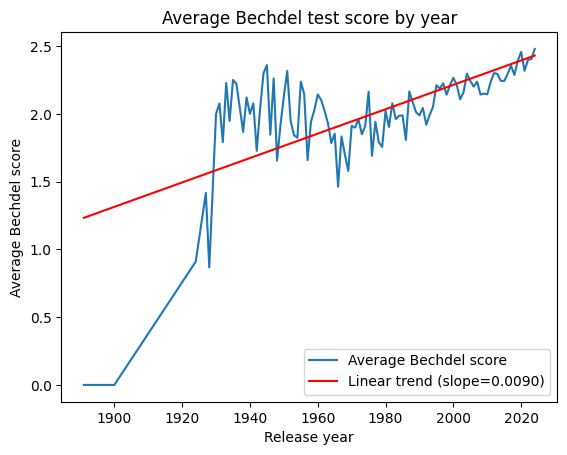

In [40]:
df_year_bechdel = df_bechdel.groupby('year')['rating'].agg('mean').reset_index() # Here, we reset index to get the year as a column
df_year_bechdel = df_year_bechdel.rename(columns={'rating':'avg_bechdel_score'})

slope, intercept, rvalue, pvalue, stderr = stats.linregress(df_year_bechdel['year'],df_year_bechdel['avg_bechdel_score'])

sns.lineplot(data=df_year_bechdel, x='year', y='avg_bechdel_score', label='Average Bechdel score')
plt.plot(df_year_bechdel['year'], slope*df_year_bechdel['year']+intercept, color='red',label=f'Linear trend (slope={slope:.4f})')

plt.legend()

plt.title('Average Bechdel test score by year')
plt.xlabel('Release year')
plt.ylabel('Average Bechdel score');

print(f"Pearson Correlation Coefficient: {rvalue:.4f}, p-value: {pvalue}, intercept={intercept:.2f}")


By these results, we observe that average Bechdel test scores have increased over the years, as indicated by the positive slope of the regression line. The Pearson correlation coefficient (r=0.3294) suggests a moderate positive relationship between the year and the Bechdel test results. However, the r^2 value (10.85%) implies that most of the variance (~89%) in Bechdel test results is explained by factors other than time, such as genre, budget, or country of origin.

The p-value (0.00785) is statistically significant at the α=0.05 level, providing strong evidence that this relationship is unlikely to have occurred due to chance. Nevertheless, the effect size is relatively modest, so we should interpret the results with caution.

In [41]:
df_year_bechdel = df_bechdel.groupby('year')['rating'].agg('mean').reset_index() # Here, we reset index to get the year as a column
df_year_bechdel = df_year_bechdel.rename(columns={'rating':'avg_bechdel_score'})

# Linear regression between the year of release and the average bechdel score
slope, intercept, rvalue, pvalue, stderr = linregress(df_year_bechdel['year'], df_year_bechdel['avg_bechdel_score'])

df_year_bechdel['trendline'] = slope * df_year_bechdel['year'] + intercept

df_num_films = df_bechdel.groupby('year')['rating'].count().reset_index(name='num_films')

df_year_bechdel = pd.merge(df_year_bechdel, df_num_films, on='year', how='left')

first_film_score_3 = df_bechdel[df_bechdel['rating'] == 3].iloc[0]

fig = go.Figure()

# Plotting the average Bechdel score line
fig.add_trace(go.Scatter(
    x=df_year_bechdel['year'],
    y=df_year_bechdel['avg_bechdel_score'],
    mode='lines+markers',
    name='Average Bechdel Score',
    line=dict(color='#392F5A'),
    marker=dict(size=6),
    hovertemplate=(
        "Year: %{x}<br>"  # Year
        "Average Bechdel Score: %{y:.2f}<br>"  # Bechdel score
        "Number of Films: %{customdata[0]}<br>"  # Number of films
        "<extra></extra>"  # Removes extra default information
    ),
    customdata=df_year_bechdel[['num_films']].values  # Pass number of films to customdata
))

# Plotting the trendline
fig.add_trace(go.Scatter(
    x=df_year_bechdel['year'],
    y=df_year_bechdel['trendline'],
    mode='lines',
    name=f'Trendline (slope={slope:.4f})',
    line=dict(color='red', dash='dash'),
    hovertemplate=(
        "Year: %{x}<br>"  # Year
        "Trendline Value: %{y:.2f}<br>"  # Trendline value
        "<extra></extra>"  # Removes extra default information
    )
))

# Plotting the first film with a score of 3 as a special point
fig.add_trace(go.Scatter(
    x=[first_film_score_3['year']],  # Year of the first film with score 3
    y=[first_film_score_3['rating']],  # Bechdel score of that film (3)
    mode='markers',
    name='First Film with Score 3',
    marker=dict(color='green', size=10, symbol='star'),
    hovertemplate=(
        f"Film: {first_film_score_3['title']}<br>"  # Film title
        f"Year: {first_film_score_3['year']}<br>"  # Film year
        f"Bechdel Score: {first_film_score_3['rating']}<br>"  # Bechdel score
        "<extra></extra>"  # Removes extra default information
    )
))

fig.update_layout(
    title='Average Bechdel Test Score by Year',
    xaxis=dict(title='Release Year'),
    yaxis=dict(title='Average Bechdel Score'),
    legend=dict(title='Legend'),
    template='plotly_white'
)

# Displaying Pearson correlation
print(f"Pearson Correlation Coefficient: {rvalue:.4f}, p-value: {pvalue:.4e}, intercept={intercept:.2f}")

fig.show()

Pearson Correlation Coefficient: 0.6415, p-value: 4.8970e-13, intercept=-15.79


Based on this analysis, we can propose the following two theories:

The Bechdel test results have improved over time, suggesting a gradual shift towards more meaningful female representation in films. Women were largely absent from lead roles in the early years of cinema, as evidenced by the lower Bechdel test scores for films released before 1920.

These findings highlight both the historical progression of women's roles in film and the growing significance of the Bechdel test as a measure of female representation in cinema.

### Bechdel Test Results in Different World Regions

To analyze how the Bechdel test results have evolved across various world regions, we opted to categorize the films by continent. This approach was chosen to avoid the complexities of geopolitical definitions. By utilizing the pycountry_convert library, we can efficiently convert countries into their respective continents.

For simplicity and based on the assumption that the first country listed in the data is the primary producer or responsible entity for the film, we decided to use only the first country in the list to determine the continent.

In [42]:
# Convert release_date to datetime format (if it's not already in datetime)
data_original['release_date'] = pd.to_datetime(data_original['release_date'], errors='coerce')

data_original['year'] = data_original['release_date'].dt.year

df_movies_bechdel = pd.merge(data_original, df_bechdel, how='inner', on=['title', 'year'])


df_movies_bechdel = df_movies_bechdel.rename(columns={'rating':'bechdel_score'})
df_movies_bechdel = df_movies_bechdel.drop(columns=['id']) 
df_movies_bechdel = df_movies_bechdel.drop_duplicates(['title','Wiki_ID'])

In [43]:
df_movies_bechdel['Countries'].value_counts()

def get_continent(country_list):
    try:
        country_dict=json.loads(country_list)

        if not country_dict:
            return None

        country_name = list(country_dict.values())[0] #I might need to have different continents! Here I only have the first one!
        country_alpha2=pc.country_name_to_country_alpha2(country_name)
        return pc.country_alpha2_to_continent_code(country_alpha2)
    except KeyError or IndexError:
        return None

df_movies_bechdel['continent']=df_movies_bechdel['Countries'].apply(get_continent)

df_movies_bechdel['continent'].value_counts()

continent
NA    2487
EU     398
AS     124
OC      21
SA       4
Name: count, dtype: int64

We now only want to keep years with at least 5 movies for each country region

In [44]:
region_threshold = 5  # Minimum number of movies per year for each region

region_year_counts = df_movies_bechdel.groupby(['continent', 'year']).size().reset_index(name='movie_count')

valid_years_per_region = region_year_counts[region_year_counts['movie_count'] >= region_threshold].groupby('continent')['year'].apply(set)

def filter_by_region_and_year(row):
    return row['year'] in valid_years_per_region.get(row['continent'], set())

df_movies_bechdel_filtered = df_movies_bechdel[df_movies_bechdel.apply(filter_by_region_and_year, axis=1)]


Seeing how little movies we have in Oceania and South America in the database, we will only try to see the trend in the Bechdel score along the years for Europe, Asia and North America.

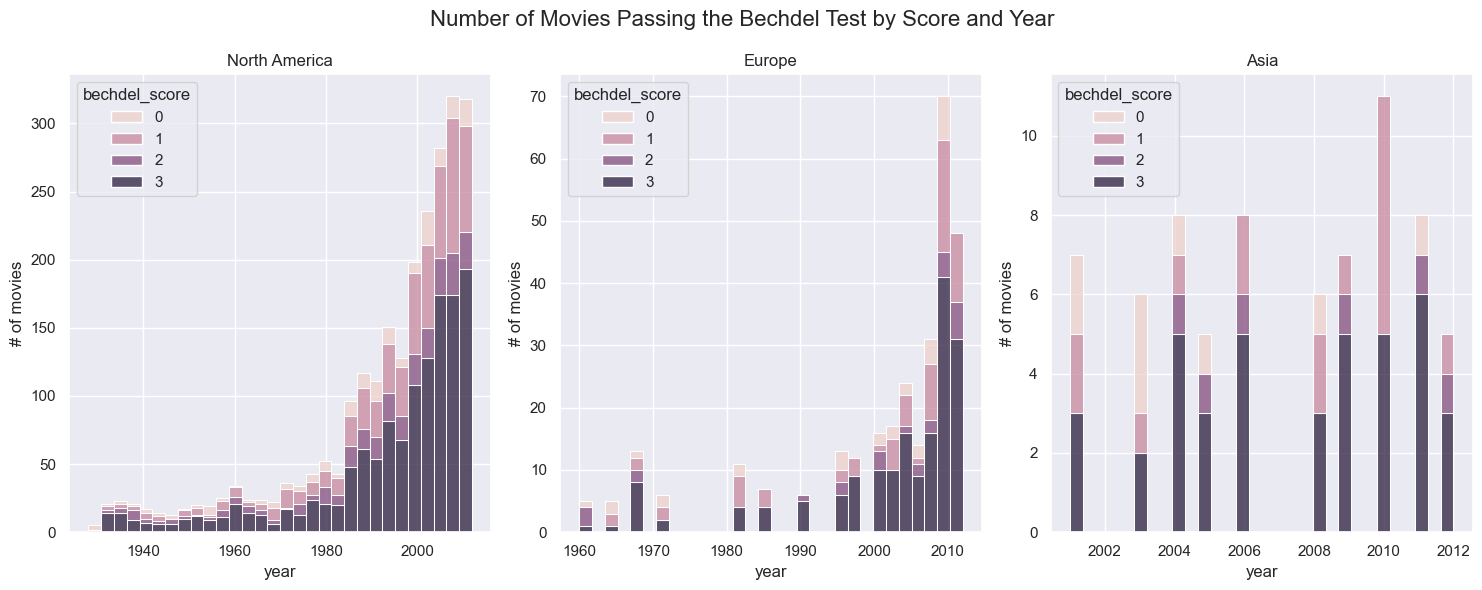

In [45]:
sns.set()
fig, axes = plt.subplots(1, 3, figsize=(15, 6))
fig.suptitle('Number of Movies Passing the Bechdel Test by Score and Year', fontsize=16)

sns.histplot(
    data=df_movies_bechdel_filtered[df_movies_bechdel_filtered['continent'] == 'NA'],
    x='year', hue='bechdel_score', multiple='stack', bins=30, ax=axes[0]
).set(title='North America', ylabel='# of movies')

sns.histplot(
    data=df_movies_bechdel_filtered[df_movies_bechdel_filtered['continent'] == 'EU'],
    x='year', hue='bechdel_score', multiple='stack', bins=30, ax=axes[1]
).set(title='Europe', ylabel='# of movies')

sns.histplot(
    data=df_movies_bechdel_filtered[df_movies_bechdel_filtered['continent'] == 'AS'],
    x='year', hue='bechdel_score', multiple='stack', bins=30, ax=axes[2]
).set(title='Asia', ylabel='# of movies')

plt.tight_layout()
plt.show()

The small number of films we have in Europe and Asia does not allow for a good representation. This is why this approach was abandoned, and we decided to study the average bechdel score test in different countries.

In [46]:
color_scale = [
    [0, "#4ea2dd"],  # The start color
    [1, "#ff4f41"]   # The end color
] 

def get_country_info(country_list):
    try:
        country_dict = json.loads(country_list)

        if not country_dict:
            return None

        # This assumes the first country in the list is the most relevant
        country_name = list(country_dict.values())[0]
        return country_name  # Return country name directly
    except (KeyError, IndexError):
        return None

df_movies_bechdel['country_name'] = df_movies_bechdel['Countries'].apply(get_country_info)

# Here, we merge outdated countries like the Soviet Union or west germany with their current equivalent or countries that are parts of other countries
country_merge_map = {
    "West Germany": "Germany",
    "Soviet Union": "Russia",
    "Korea": "South Korea",
    "England": "United Kingdom",
}

df_movies_bechdel['country_name'] = df_movies_bechdel['country_name'].replace(country_merge_map)

df_country_avg = (
    df_movies_bechdel.groupby('country_name')
    .agg(avg_bechdel_score=('bechdel_score', 'mean'),
         movie_count=('bechdel_score', 'count'))  # Count number of films per country
    .reset_index()
)

fig = px.choropleth(
    df_country_avg,
    locationmode='country names',  
    locations="country_name",  
    color="avg_bechdel_score",
    hover_name="country_name",  
    hover_data={
        "avg_bechdel_score": True, 
        "movie_count": True
    },  # Show Bechdel score and movie count
    color_continuous_scale=color_scale,
    title="Average Bechdel Score by Country"
)

#We update the hover information
fig.update_traces(
    hovertemplate="<b>%{location}</b><br>" +  # Country name
                  "Average Bechdel Score: %{customdata[0]:.2f}<br>" +  # Average Bechdel score
                  "Number of films considered: %{customdata[1]}<br>"  # Movie count 
)

fig.update_layout(
    coloraxis_colorbar_title="Average Bechdel score",  # Setting the legend title
)

fig.show()


Here, it is important to see how the majority of films that are both in the Bechdel test database and in the CMU movie database are from the United States of America. But let's look at a pie chart with the top 5 countries present in this database.

In [47]:
chat_palette = ['#392F5A', '#9C8CC9', '#F58D83', '#5F8B8A', '#E4D5B7', '#FFB6A6', '#D1D8E0']

# Sorting the DataFrame by movie_count in descending order
df_country_avg_sorted = df_country_avg.sort_values(by='movie_count', ascending=False)

# Getting the top 5 countries
top_5 = df_country_avg_sorted.head(5)

# Grouping the rest into 'Others'
others = pd.DataFrame({
    'country_name': ['Others'],
    'movie_count': [df_country_avg_sorted.iloc[5:]['movie_count'].sum()]
})

# Combining the top 5 and 'Others' into one DataFrame
df_pie = pd.concat([top_5, others], ignore_index=True)

fig = px.pie(
    df_pie,
    names='country_name',  # Country names for the pie slices
    values='movie_count',  # Movie count as the values for each country
    title="Distribution of Films by Country (Top 5 + Others)",
    color='country_name',  # Optionally, add color based on country
    color_discrete_sequence=chat_palette  # Use a color palette for the countries
)

fig.update_traces(
    hovertemplate="<b>%{label}</b><br>Movie count: %{value}<br><extra></extra>"  # Clean hover format
)

# # This code is to adapt the graph to a correct size for the website
# fig.update_layout(
#     width=500,  # Set the width of the plot to 1300
#     height=500  # Optional, adjust height as needed
# )

fig.show()


As expected, 80% of the films come from the United States. This heavy U.S. representation means we should be cautious when interpreting the Bechdel scores for other countries. Drawing sociological conclusions about women's status in cinema based on global data would be premature, as many countries are underrepresented. Our study, therefore, will focus on U.S. films for more reliable conclusions.

# Inclusivity metric

The Bechdel score provides a solid foundation for developing an inclusivity metric. To build on this, we also evaluate the proportion of actresses in the movie to assess the level of female representation. However, this alone is insufficient. A movie may feature many women in minor or background roles, or conversely, a single actress who takes on the lead role. Therefore, we also consider the share of the script attributed to actresses to capture their meaningful presence in the film.


  $$
  \textbf{Inclusivity Score} = \frac{\text{Normalized Bechdel Score} + \text{Promotion of Actress} + \text{Women’s Share of the Script}}{3}
  $$


1. **Normalized Bechdel Score:** The traditional Bechdel score scaled to ensure compatibility with other metrics.<br>
2. **Promotion of Actress:** The proportion of actresses in the movie compared to actors.<br>
3. **Women’s Share of the Script:** The percentage of the script allocated to female characters.<br><br>

This approach ensures a more comprehensive and meaningful evaluation of inclusivity in movies, moving beyond the simplicity of the Bechdel Test.

In [48]:
#Load data
success_bechdel_script = pd.read_csv(data_path + 'success_bechdel_script.csv')
success_bechdel_script['incl_score'] = (success_bechdel_script['proportion_actress']+success_bechdel_script['female_script']+success_bechdel_script['Bechdel_score']/3)/3
success_bechdel_script = success_bechdel_script.dropna(subset=['incl_score'])

# Inclusivity score through the years

Pearson correlation has a coefficient of 0.454 which is significant with a p-value of 0.00373.
Spearman correlation has a coefficient of 0.347 which is higly significant with a p-value of 0.0305.


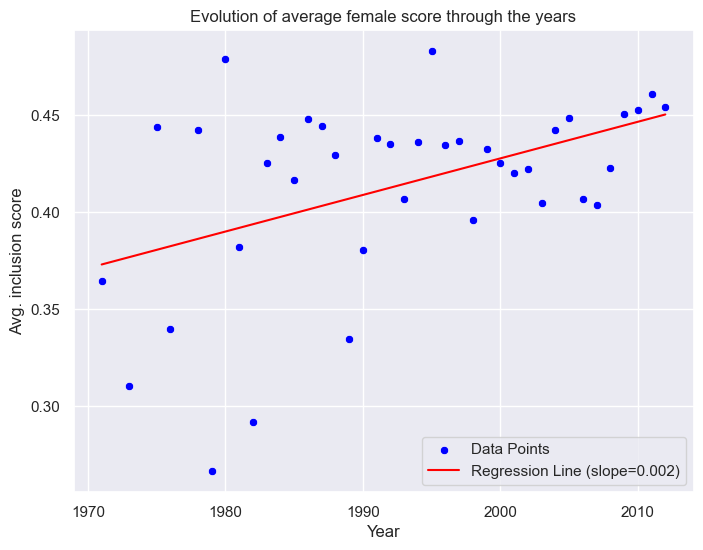

In [49]:
movies_by_year = success_bechdel_script.groupby('Year').agg(
    avg_incl_score=('incl_score', 'mean'),
    avg_female_script=('female_script', 'mean'),
    avg_success=('SuccessMetric', 'mean'),
    sample_count=('Year', 'size')
).reset_index()

movies_by_year = movies_by_year[movies_by_year['sample_count'] >= 5]

from scipy.stats import linregress
x =movies_by_year['Year']
y = movies_by_year['avg_incl_score']

slope, intercept, r_value, p_value, std_err = linregress(x, y)
regression_line = slope * x + intercept

pearson = stats.pearsonr(x, y)
print(f"Pearson correlation has a coefficient of {pearson[0]:.3} which is significant with a p-value of {pearson[1]:.3}.")

spearman = stats.spearmanr(x, y)
print(f"Spearman correlation has a coefficient of {spearman[0]:.3} which is higly significant with a p-value of {spearman[1]:.3}.")

# Plot the scatter plot and regression line
plt.figure(figsize=(8, 6))
sns.scatterplot(x=x, y=y, color='blue', label='Data Points')
plt.plot(x, regression_line, color='red', label=f'Regression Line (slope={slope:.3f})')
plt.title('Evolution of average female score through the years')
plt.xlabel('Year')
plt.ylabel('Avg. inclusion score')
plt.legend()
plt.grid(True)
plt.show()

In [50]:
movies_by_year = success_bechdel_script.groupby('Year').agg(
    avg_incl_score=('incl_score', 'mean'),
    avg_female_script=('female_script', 'mean'),
    avg_success=('SuccessMetric', 'mean'),
    sample_count=('Year', 'size')
).reset_index()

movies_by_year = movies_by_year[movies_by_year['sample_count'] >= 10]

import plotly.express as px
import pandas as pd

fig = px.line(
    movies_by_year, 
    x='Year', 
    y='avg_incl_score', 
    title='Evolution of Actress Proportion by Year',
    labels={
        'Year': 'Year',
        'proportion_actress': 'Proportion of Actresses',
    },
    markers=True
)

fig.update_layout(
    xaxis_title="Year",
    yaxis_title="Mean success score",
    template="plotly_white"
)

fig.show()

output_path_3 = figure_path + "inclusivity_years.html"
pio.write_html(fig, output_path_3)


In [51]:
import pandas as pd
import numpy as np
from scipy.stats import linregress, pearsonr, spearmanr
import plotly.graph_objects as go

# Example data: Replace this with your actual data.
movies_by_year = pd.DataFrame({
    'Year': np.arange(2000, 2021),
    'avg_incl_score': np.random.rand(21) * 10 + 50,
    'avg_female_script': np.random.rand(21) * 20 + 40,
    'avg_success': np.random.rand(21) * 15 + 70,
    'sample_count': np.random.randint(5, 20, 21)
})

# Filter the data to include only years with at least 5 samples
movies_by_year = movies_by_year[movies_by_year['sample_count'] >= 5]

# Regression analysis
x = movies_by_year['Year']
y = movies_by_year['avg_incl_score']
slope, intercept, r_value, p_value, std_err = linregress(x, y)
regression_line = slope * x + intercept

# Calculate correlations
pearson = pearsonr(x, y)
spearman = spearmanr(x, y)
print(f"Pearson correlation has a coefficient of {pearson[0]:.3} which is significant with a p-value of {pearson[1]:.3}.")
print(f"Spearman correlation has a coefficient of {spearman[0]:.3} which is highly significant with a p-value of {spearman[1]:.3}.")

# Interactive Plot
fig = go.Figure()

# Add scatter plot
fig.add_trace(go.Scatter(
    x=x, y=y,
    mode='markers+lines',
    name='Avg. Inclusion Score',
    marker=dict(size=10, color='blue'),
    line=dict(dash='dot')
))

# Add regression line
fig.add_trace(go.Scatter(
    x=x, y=regression_line,
    mode='lines',
    name=f'Regression Line (slope={slope:.3f})',
    line=dict(color='red', width=2)
))

# Customize layout
fig.update_layout(
    title='Evolution of Average Female Inclusion Score Through the Years',
    xaxis_title='Year',
    yaxis_title='Avg. Inclusion Score',
    template='plotly_white',
    legend=dict(orientation="h", yanchor="bottom", y=1.02, xanchor="right", x=1)
)

# Show plot
fig.show()


Pearson correlation has a coefficient of 0.229 which is significant with a p-value of 0.317.
Spearman correlation has a coefficient of 0.279 which is highly significant with a p-value of 0.22.


# Correlation between success and inclusivity

Pearson correlation has a coefficient of -0.125 which is higly significant with a p-value of 6.82e-05.
Spearman correlation has a coefficient of -0.126 which is higly significant with a p-value of 6.33e-05.


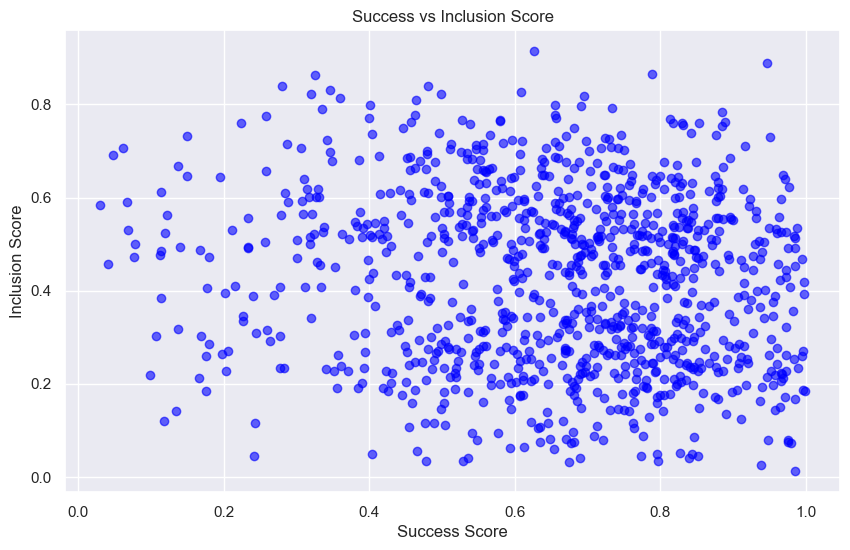

In [58]:
from scipy import stats
all_metrics_copy = all_metrics.copy()
all_metrics_copy = all_metrics_copy.dropna(subset=['incl_score','SuccessMetric'])
pearson = stats.pearsonr(all_metrics_copy['SuccessMetric'], all_metrics_copy['incl_score'])
print(f"Pearson correlation has a coefficient of {pearson[0]:.3} which is higly significant with a p-value of {pearson[1]:.3}.")

spearman = stats.spearmanr(all_metrics_copy['SuccessMetric'], all_metrics_copy['incl_score'])
print(f"Spearman correlation has a coefficient of {spearman[0]:.3} which is higly significant with a p-value of {spearman[1]:.3}.")

plt.figure(figsize=(10, 6))
plt.scatter(all_metrics_copy['SuccessMetric'], all_metrics_copy['incl_score'], alpha=0.6, color='blue')
plt.title('Success vs Inclusion Score')
plt.xlabel('Success Score')
plt.ylabel('Inclusion Score')
plt.grid(True)
plt.show()

The correlation analysis between inclusivity and movie success reveals a weak negative relationship. The Pearson correlation is -0.125 (p-value = 6.82e-05), and the Spearman correlation is -0.126 (p-value = 6.33e-05), both statistically significant. While the relationship is weak, the negative trend suggests that higher inclusivity is associated with slightly lower success metrics. However, the small effect size highlights the need to explore potential confounding factors and broader context before drawing definitive conclusions.


## Correlation speach share and Success score

Pearson correlation has a coefficient of -0.154 which is higly significant with a p-value of 9.35e-07.
Spearman correlation has a coefficient of -0.155 which is higly significant with a p-value of 7.38e-07.


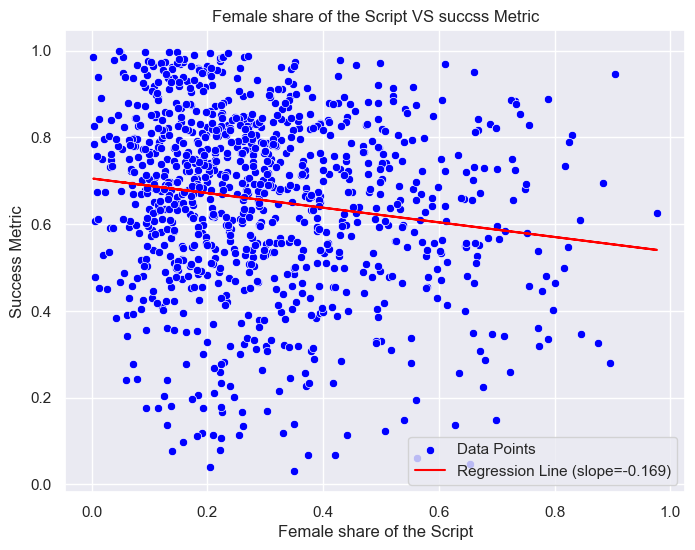

In [59]:
from scipy.stats import linregress

success_bechdel_script = success_bechdel_script.dropna(subset=['SuccessMetric'])
x = success_bechdel_script['female_script']
y = success_bechdel_script['SuccessMetric']

slope, intercept, r_value, p_value, std_err = linregress(x, y)
regression_line = slope * x + intercept
pearson = stats.pearsonr(x, y)
print(f"Pearson correlation has a coefficient of {pearson[0]:.3} which is higly significant with a p-value of {pearson[1]:.3}.")

spearman = stats.spearmanr(x, y)
print(f"Spearman correlation has a coefficient of {spearman[0]:.3} which is higly significant with a p-value of {spearman[1]:.3}.")

# Plot the scatter plot and regression line
plt.figure(figsize=(8, 6))
sns.scatterplot(x=x, y=y, color='blue', label='Data Points')
plt.plot(x, regression_line, color='red', label=f'Regression Line (slope={slope:.3f})')
plt.title('Female share of the Script VS succss Metric')
plt.xlabel('Female share of the Script')
plt.ylabel('Success Metric')
plt.legend()
plt.grid(True)
plt.show()

## Correlation speach share and bechdel score

In [60]:
from scipy.stats import linregress
x = success_bechdel_script['Bechdel_score']
y = success_bechdel_script['female_script']

pearson = stats.pearsonr(x, y)
print(f"Pearson correlation has a coefficient of {pearson[0]:.3} which is higly significant with a p-value of {pearson[1]:.3}.")

spearman = stats.spearmanr(x, y)
print(f"Spearman correlation has a coefficient of {spearman[0]:.3} which is higly significant with a p-value of {spearman[1]:.3}.")



Pearson correlation has a coefficient of 0.53 which is higly significant with a p-value of 4.87e-74.
Spearman correlation has a coefficient of 0.558 which is higly significant with a p-value of 1.59e-83.


## Correlation speach share and proportion of actress

Pearson correlation has a coefficient of 0.623 which is higly significant with a p-value of 3.69e-109.
Spearman correlation has a coefficient of 0.58 which is higly significant with a p-value of 1.49e-91.


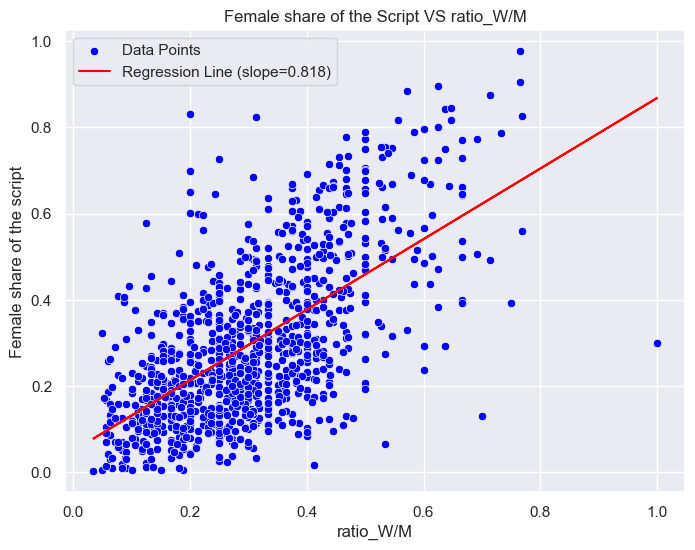

In [61]:
from scipy.stats import linregress
x = success_bechdel_script['proportion_actress']
y = success_bechdel_script['female_script']

slope, intercept, r_value, p_value, std_err = linregress(x, y)
regression_line = slope * x + intercept

pearson = stats.pearsonr(x, y)
print(f"Pearson correlation has a coefficient of {pearson[0]:.3} which is higly significant with a p-value of {pearson[1]:.3}.")

spearman = stats.spearmanr(x, y)
print(f"Spearman correlation has a coefficient of {spearman[0]:.3} which is higly significant with a p-value of {spearman[1]:.3}.")

# Plot the scatter plot and regression line
plt.figure(figsize=(8, 6))
sns.scatterplot(x=x, y=y, color='blue', label='Data Points')
plt.plot(x, regression_line, color='red', label=f'Regression Line (slope={slope:.3f})')
plt.title('Female share of the Script VS ratio_W/M')
plt.xlabel('ratio_W/M')
plt.ylabel('Female share of the script')
plt.legend()
plt.grid(True)
plt.show()

As expected, the script share is highly correlated to the proportion of actresses

## Tropes correlation

Rather then depicting the real-life women, cinema tends to perpetuate negative gender stereotypes which are reflected in the roles women play in films.
Some of our hypothesis is that women often receive secondary ad stereotypical representation tied to traditional roles of wives, lovers, mothers....
We think also that they are portrayed as overly emotional or dramatic.
We will also try to identify the tropes that leading to the greteast success.


In [63]:
characters = pd.read_csv(original_data + 'CMU_dataset/character_metadata.csv')
# Parse the JSON strings in the data column of the tropes dataset
tropes['data'] = tropes['data'].apply(ast.literal_eval)
# Normalize the 'data' dictionaries into separate columns
data_expanded = pd.json_normalize(tropes['data'])
# Combine the 'trope' column with the expanded data columns
tropes = pd.concat([tropes['trope'], data_expanded], axis=1)

KeyError: 'data'

**Data Enrichment**: Enrichment of the tropes dataset with additional characteristics from the characters dataset (e.g., gender, height, ethnicity, age at release,genre ...)

In [57]:
# Ensure the actor column is named consistently in both DataFrames
characters.rename(columns={'actor_name': 'actor'}, inplace=True)

# Create a dictionary mapping from actor to gender
gender_mapping = characters.set_index('actor')['actor_gender'].to_dict()
height_mapping = characters.set_index('actor')['actor_height'].to_dict()
ethnicity_mapping = characters.set_index('actor')['actor_ethnicity'].to_dict()
age_mapping = characters.set_index('actor')['actor_age_movie_released'].to_dict()

# Use the mapping to add the gender column in tropes based on the actor column
tropes['actor_gender'] = tropes['actor'].map(gender_mapping)
tropes['actor_height'] = tropes['actor'].map(height_mapping)
tropes['actor_ethnicity'] = tropes['actor'].map(ethnicity_mapping)
tropes['actor_age_movie_released'] = tropes['actor'].map(age_mapping)

# Check for the matching column between tropes['id'] and each ID column in characters
matching_column = None
for col in ['character/actor_ID', 'character_ID', 'Actor_ID']:
    if tropes['id'].isin(characters[col]).any():
        matching_column = col
        print(f"Matching column found: {col}")
        break

if matching_column:
    # Perform the merge and directly add the Movie_ID column to the existing tropes DataFrame
    tropes = tropes.merge(
        characters[['Movie_ID', matching_column]],
        left_on='id',
        right_on=matching_column,
        how='left'
    )

# Drop the extra column used for merging if you don’t need it anymore
tropes.drop(columns=[matching_column], inplace=True)

# Rename the Movie_ID column to movie_id in tropes if desired
tropes.rename(columns={'Movie_ID': 'movie_id'}, inplace=True)

# Merge ethnicity label into tropes based on actor_ethnicity and ethnicity_ID
tropes = pd.merge(tropes, ethnicity_df[['ethnicity_ID', 'ethnicity_label']], left_on='actor_ethnicity', right_on='ethnicity_ID', how='left')

# Drop the redundant ethnicity_ID column if it's no longer needed
tropes.drop(columns=['ethnicity_ID'], inplace=True)

# Merge genres into tropes DataFrame based on Movie_ID
tropes = pd.merge(tropes, data_success[['Movie_ID', 'Genres', 'SuccessMetric']], left_on='movie_id', right_on='Movie_ID', how='left')

# Drop redundant column if necessary
tropes.drop(columns=['Movie_ID'], inplace=True)


Matching column found: character/actor_ID


**Filter**: seperate female characters from mens

In [ ]:
tropes_w = tropes.loc[tropes['actor_gender'] =='F']
tropes_m = tropes.loc[tropes['actor_gender'] =='M']

**Calculating descriptive statistics**

In [ ]:
tropes_w['trope'].describe()

count              69
unique             21
top       dumb_blonde
freq               10
Name: trope, dtype: object

In [ ]:
tropes_m['trope'].describe()

count                   431
unique                   65
top       crazy_jealous_guy
freq                     25
Name: trope, dtype: object

There is a higher variety of tropes for male characters (65 unique versus 21 for female characters), and while "dumb_blonde" is the most frequent trope for women, "crazy_jealous_guy" dominates the male tropes in terms of frequency. The women in this dataset is additionaly underepresented, but we will continue to further analyze the distribution of each trope and compare between women and men.

**Distribution of each trope for both women and men, to see which tropes are more frequently associeted with each gender**

**Most frequent tropes in cinema for female characters**: As expected the cinema frequently relies on stereotypical portrayals that reinforce traditional gender biases. Tropes like "dumb blonde," "brainless beauty," "valley girl," and "prima donna" dominate, emphasizing superficial or appearance-focused qualities, which align with stereotypes that reduce women to their looks or perceived lack of intelligence.
Emotionally charged roles, such as "ophelia," "broken bird," and "chanteuse," suggest that women are often portrayed as overly emotional, fragile, or in need of rescue, reinforcing the notion that women lack emotional stability or independence. Thus, female characters are more often defined by their personalities or relationships rather than ambition, skills, or leadership. 

**Chi-square test for gender and trope association**: Let's see if the gender and trope type are independent of each other.

In [ ]:
# Create contingency table
contingency_table = pd.crosstab(tropes['actor_gender'], tropes['trope'])
chi2, p, dof, expected = chi2_contingency(contingency_table)

print("Chi-square Test:")
print("Chi2 Statistic:", chi2)
print("P-value:", p)

Chi-square Test:
Chi2 Statistic: 369.8513527525936
P-value: 5.592160386860096e-42


The Chi-square statistic of 370.63 indicates a strong deviation from the expected frequency distribution of the tropes between different genders. The very small p-value (close to 0) suggests that the result is statistically significant, meaning there is a highly significant association between the gender of the actor and the trope they portray. This means that the distribution of tropes across genders is not due to random chance, but rather there is a clear relationship between the two variables.

In [ ]:
tropes_w['trope_space'] = tropes_w['trope'].str.replace('_', ' ')
tropes_m['trope_space'] = tropes_m['trope'].str.replace('_', ' ')

In [ ]:
def plot_top_tropes(gender='F', top_n=10):
    if gender == 'F':
        tropes_data = tropes_w['trope_space'].value_counts(normalize=True).head(top_n) * 100
        title = f"Top {top_n} Tropes for Women"
        color = '#ff4f41'  # Red for women
        output_path = r"C:\Users\Myriam Charfeddine\Documents\GitHub\SAR-ADA_website\assets\top_tropes_women.html"
    else:
        tropes_data = tropes_m['trope_space'].value_counts(normalize=True).head(top_n) * 100
        title = f"Top {top_n} Tropes for Men"
        color = '#4ea2dd'  # Blue for men
        output_path = r"C:\Users\Myriam Charfeddine\Documents\GitHub\SAR-ADA_website\assets\top_tropes_men.html"

    # Create bar plot
    fig = px.bar(
        tropes_data,
        x=tropes_data.values,
        y=tropes_data.index,
        orientation='h',
        title=title,
        labels={'x': 'Percentage (%)', 'index': 'Trope'},
        template='seaborn'
    )

    # Update marker colors and background to match previous style
    fig.update_traces(marker_color=color)
    fig.update_layout(
        plot_bgcolor='#eaeaea',
        paper_bgcolor='rgb(245,245,245)',
        title=dict(
            font=dict(size=20, color='#2c3e50'),
            x=0.5,
            xanchor='center'
        ),
        xaxis=dict(
            title=dict(font=dict(size=16, color='#2c3e50')),
            tickfont=dict(size=12, color='#2c3e50')
        ),
        yaxis=dict(
            title='Type of character',  # Change this to your desired y-axis title
            title_font=dict(size=16, color='#2c3e50'),
            tickfont=dict(size=12, color='#2c3e50')
        ),
        hovermode='y unified',
        margin=dict(t=80, b=60, l=60, r=60)
    )

    # Show the figure
    fig.show()
    pio.write_html(fig, output_path)

# Interactive widget
interact(
    plot_top_tropes,
    gender=Dropdown(options=[('Women', 'F'), ('Men', 'M')], value='F'),
    top_n=(5, 20, 1)
)


interactive(children=(Dropdown(description='gender', options=(('Women', 'F'), ('Men', 'M')), value='F'), IntSl…

<function __main__.plot_top_tropes(gender='F', top_n=10)>

## Correlation between women trope and the success of a movie

### Regression analysis: Measure how much each trope contributes to the success metric, even when other factors are considered.
For example, an "adventurous" trope might perform better in action genres, or characters of certain ages or ethnic backgrounds might resonate more with audiences in particular tropes. By including these variables, regression helps us understand whether success depends on a combination of these factors.

**Is the relationship statistically significant?** A significant result suggests that the observed effect of a trope, genre and ethnicity on success is unlikely to be due to chance, giving us more confidence in our findings.

In [ ]:
import pandas as pd
import numpy as np
import statsmodels.api as sm

# Explode 'Genres' and drop rows missing required columns
tropes_w_exploded = tropes_w.explode('Genres')
tropes_w_exploded = tropes_w_exploded.dropna(subset=['SuccessMetric', 'actor_age_movie_released', 'ethnicity_label'])

# One-hot encode categorical variables
genre_encoded = pd.get_dummies(tropes_w_exploded['Genres'], prefix='Genre', dtype=bool)
trope_encoded = pd.get_dummies(tropes_w_exploded['trope'], prefix='Trope', dtype=bool)
ethnicity_encoded = pd.get_dummies(tropes_w_exploded['ethnicity_label'], prefix='Ethnicity', dtype=bool)

# Combine features
data_for_regression = pd.concat([
    tropes_w_exploded[['SuccessMetric', 'actor_age_movie_released']].reset_index(drop=True),
    genre_encoded.reset_index(drop=True),
    trope_encoded.reset_index(drop=True),
    ethnicity_encoded.reset_index(drop=True)
], axis=1)

# Convert all columns to numeric, coerce errors to NaN
data_for_regression = data_for_regression.apply(pd.to_numeric, errors='coerce')

# Drop rows with NaN values
data_for_regression = data_for_regression.dropna()

# Define X (independent variables) and y (dependent variable)
X = data_for_regression.drop(columns=['SuccessMetric'])
y = data_for_regression['SuccessMetric']

# Convert boolean columns to float
X = X.astype(float)
y = y.astype(float)

# Add a constant to the DataFrame
X = sm.add_constant(X)

# Fit the OLS model using DataFrame X and Series y
model = sm.OLS(y, X).fit()

print(model.summary())

                            OLS Regression Results                            
Dep. Variable:          SuccessMetric   R-squared:                       0.945
Model:                            OLS   Adj. R-squared:                  0.889
Method:                 Least Squares   F-statistic:                     16.80
Date:                Thu, 19 Dec 2024   Prob (F-statistic):           2.48e-25
Time:                        11:45:06   Log-Likelihood:                 231.40
No. Observations:                 141   AIC:                            -318.8
Df Residuals:                      69   BIC:                            -106.5
Df Model:                          71                                         
Covariance Type:            nonrobust                                         
                                     coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------
const       

In [ ]:
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:          SuccessMetric   R-squared:                       0.945
Model:                            OLS   Adj. R-squared:                  0.889
Method:                 Least Squares   F-statistic:                     16.80
Date:                Thu, 19 Dec 2024   Prob (F-statistic):           2.48e-25
Time:                        11:45:06   Log-Likelihood:                 231.40
No. Observations:                 141   AIC:                            -318.8
Df Residuals:                      69   BIC:                            -106.5
Df Model:                          71                                         
Covariance Type:            nonrobust                                         
                                     coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------
const       

**R-squared:**  0.945, the model explains 96.5% of the variance in the SuccessMetric. This suggests that the predictors (genre, tropes, and ethnicity) together provide a strong explanation for movie success.

**Adjusted R-squared:** 0.889, this high value accounts for the number of predictors in the model, suggesting that even with many predictors, the model is robust.

**Durbin-Watson:** 0.873, which suggests possible positive autocorrelation in the residuals. Ideally, this should be closer to 2 for no autocorrelation.
Condition Number: 2.01e+18, which is very high, indicating potential multicollinearity. This suggests that some predictor variables may be highly correlated with each other.

**P-values and Significance:** The coefficients with a p-value less than 0.05 are statistically significant, suggesting a reliable effect on the SuccessMetric.

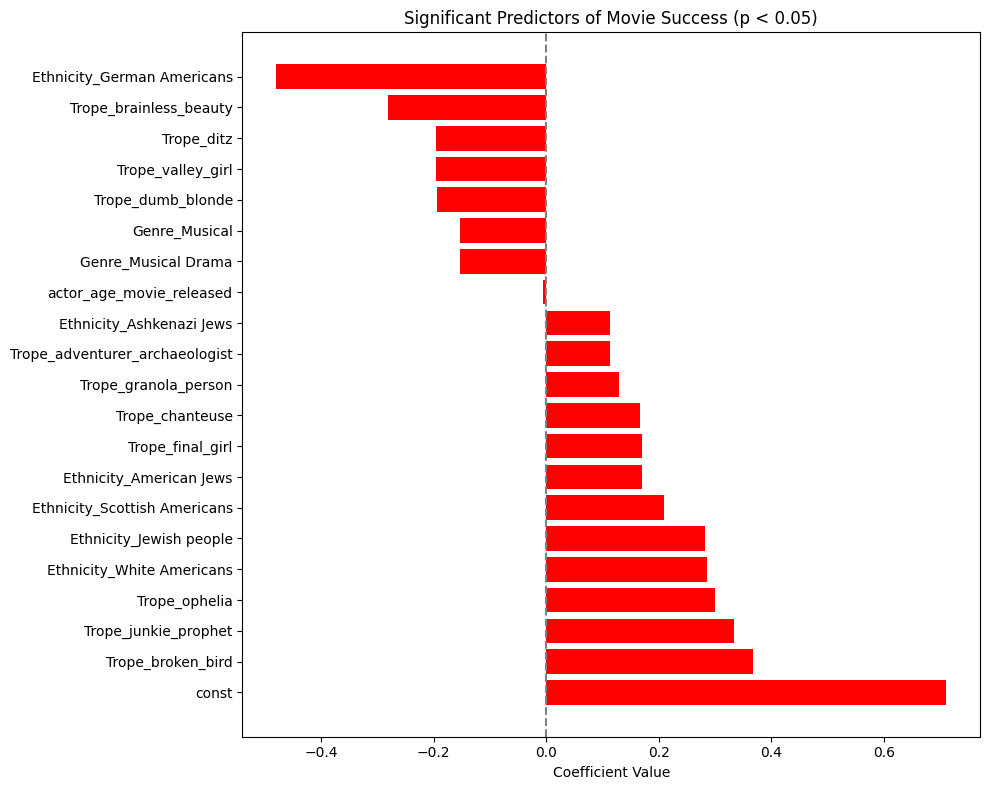

In [ ]:
# Get the significant variables from the model summary
significant_vars = model.summary2().tables[1]
significant_vars = significant_vars[significant_vars['P>|t|'] < 0.05]

# Sort by the absolute value of the coefficients for better visualization
significant_vars = significant_vars.sort_values(by='Coef.', ascending=False)


plt.figure(figsize=(10, 8))
plt.barh(significant_vars.index, significant_vars['Coef.'], color='red')
plt.xlabel('Coefficient Value')
plt.title('Significant Predictors of Movie Success (p < 0.05)')
plt.axvline(0, color='gray', linestyle='--')
plt.tight_layout()
plt.show()


Each bar in the plot corresponds to the coefficient for a specific variable (like Ethnicity_White Americans, Tope_dumb_blonde, etc.).
Positive coefficients push the SuccessMetric higher (more successful movie).
Negative coefficients suggest a negative relationship, meaning an increase in that variable could decrease the SuccessMetric.

# Success Score Prediction

After analyzing all these correlations, we want to determine whether it is possible to predict success. The producer, in addition to aiming for a good inclusion score, would like recommendations on which features to prioritize to improve the success rate. For instance, where to produce the film, which actor characteristics tend to perform better, in which language to shoot the film...

In [3]:
#Create list of ethncitiy for each movie
grouped = data_character.groupby('Movie_title.1')['ethnicity.1'].apply(list).reset_index()
grouped = grouped.rename(columns={'ethnicity.1': 'ethnicity_list'})

grouped['Normalized_Title'] = grouped['Movie_title.1'].str.replace(" ", "").str.lower()
data_success['Normalized_Title'] = data_success['title'].str.replace(" ", "").str.lower()
all_metrics['Normalized_Title'] = all_metrics['title'].str.replace(" ", "").str.lower()

#Create the dataFrame containing all features for the prediction and clean it 
merged_df = pd.merge(data_success, grouped, on='Normalized_Title', how='left')
merged_df1 = pd.merge(merged_df, all_metrics, on='Normalized_Title', how='left')
merged_df1= merged_df1.loc[:, ~merged_df1.columns.str.endswith('_y')]
merged_df2= merged_df1.dropna(subset=['incl_score'])

In [4]:
# Create a dataFrame with the unique value of Genres and a list of SuccessMetrics
merged_df2['Genres_x'] = merged_df2['Genres_x'].apply(lambda x: ast.literal_eval(x) if isinstance(x, str) else x)

rows = []
for _, row in merged_df2.iterrows():
    for genre in row['Genres_x']:
        rows.append({
            'Genres': genre,
            'SuccessMetric': row['SuccessMetric_x']
        
        })

exploded_df = pd.DataFrame(rows)

#Group by genre and aggregate SuccessMetric as list
grouped = exploded_df.groupby('Genres').agg(
    SuccessMetric=('SuccessMetric', list)
).reset_index()

#Sorted by Genres
grouped_sorted = grouped.sort_values('Genres').reset_index(drop=True)
grouped_sorted['Genres_Count'] = grouped_sorted['SuccessMetric'].apply(len)
print("The total number of unique genres is:", len(grouped_sorted))

The total number of unique genres is: 240


However, we noticed that there are many unique genres, so we decided to focus on a select few, the main genres, with at least 70 movies each.

In [5]:
#Select only genres for which we have at leasr 70 movies in the dataset
grouped_filtered = grouped_sorted[grouped_sorted['Genres_Count'] >= 70]
list_genres = grouped_filtered['Genres'].str.split(', ').explode().unique().tolist()
merged_df2['Genres_x'] = merged_df2['Genres_x'].apply(lambda genres: [genre for genre in genres if genre in list_genres])

We observed the same pattern for other categorical features, with too many unique values. Therefore, for each feature, we will focus on the most representative ones in our dataset.

In [6]:
#Select only ethnicities represented in at least 70 movies in the dataset

list_ethnicities = ['African Americans','American Jews','British','Canadian','Canadian Americans','English Americans','English people','German Americans','Irish Americans','Indians'
                   ,'Irish migration to Great Britain', 'Irish people','Italian Americans','Jewish people','Scottish Americans','Scottish people','Swedish Americans','Welsh people'
                   ,'White Americans','White people']

merged_df2['ethnicity_list'] = merged_df2['ethnicity_list'].apply(lambda ethnis: [ethni for ethni in ethnis if ethni in list_ethnicities])

In [7]:
#Select only Languages for which we have at least 25 movies in the dataset

list_languages = ['English Language','French Language','German Language','Italian Language','Japanese Language', 'Russian Language','Spanish Language']
merged_df2['Languages_x'] = merged_df2['Languages_x'].apply(lambda languages: [language for language in languages if language in list_languages])

In [8]:
#Select only languages of at least 10 movies in the dataset

list_countries= ['Australia','Canada','France','Germany','Italy','Japan','New Zealand','Spain','United Kingdom','United States of America']
merged_df2['Countries_x'] = merged_df2['Countries_x'].apply(lambda countries: [country for country in countries if country in list_countries])

In [9]:
merged_df2 = merged_df2.rename(columns=lambda col: col[:-1] if col.endswith('x') else col)
merged_df2 = merged_df2.rename(columns=lambda col: col[:-1] if col.endswith('_') else col)

In [10]:
print("The columns of the dataset are:",merged_df2.columns.tolist())

The columns of the dataset are: ['Unnamed: 0', 'Wiki_ID', 'Movie_ID', 'title', 'release_date', 'BoxOfficeRevenue', 'Runtime', 'Languages', 'Countries', 'Genres', 'Year', 'BoxOfficeStandardize', 'budget', 'Net_revenue', 'rating', 'BoxOfficeRank', 'RatingRank', 'SuccessMetric', 'Normalized_Title', 'Movie_title.1', 'ethnicity_list', 'script_id', 'imdb_id', 'Bechdel_score', 'ratio_W/M', 'incl_score']


We decided to remove all columns that are not relevant for predicting the success metric, as well as features related to the success metric that would not be known before producing the movie.

In [11]:
columns_to_drop = ['script_id','imdb_id', 'Wiki_ID', 'Movie_ID', 'release_date', 'BoxOfficeRevenue', 'BoxOfficeStandardize', 'Net_revenue','RatingRank','BoxOfficeRank','Normalized_Title','title','Movie_title.1','rating']  # Replace with actual column names
final_pred = merged_df2.drop(columns=columns_to_drop)

To make predictions, the column we aim to predict must not contain any NaN values.

In [12]:
final_pred = final_pred.dropna(subset=['SuccessMetric'])

In [13]:
print("Number of NaN values in each column:",final_pred.isna().sum())

Number of NaN values in each column: Unnamed: 0        0
Runtime           4
Languages         0
Countries         0
Genres            0
Year              0
budget            0
SuccessMetric     0
ethnicity_list    0
Bechdel_score     0
ratio_W/M         0
incl_score        0
dtype: int64


Since we want to reduce the number of NaN values, we will also remove the 4 rows that contain NaN values in the runtime column

In [14]:
final_pred = final_pred.dropna(subset=['Runtime'])

Because we have many categorical variables, we need to convert them into numerical values for prediction. The simplest approach would be to use One-Hot Encoding, but we decided to map the categorical variables based on the success metric. We will split the dataset into training and testing sets. The data is divided such that 80% is used for training the model, and 20% is reserved for testing the model's performance. To handle categorical variables, Target Encoding is applied. Categorical columns, such as those for languages, countries, genres, and ethnicities, are expanded into separate columns, each representing a unique category. Then each category is replaced by the mean of the target variable (SuccessMetric) for that category. This method helps in dealing with high-cardinality categorical variables. Additionally, smoothing is applied with a smoothing parameter of 0.5, which helps to avoid overfitting by adjusting the encoding in a way that balances the category mean with the overall target distribution.  Before encoding, missing values in the categorical columns are handled by filling them with the mode (the most frequent value) or a default value like 'Unknown' when the mode is empty. This ensures that there are no missing values when applying the encoding process.  After the categorical features are encoded, the dataset is separated into features (X) and the target variable (SuccessMetric). The features will be used to train the model, while the target variable is the one we aim to predict.

In [15]:
# Separate categorical list unique value into separate columns
#Genres
genres_columns = final_pred['Genres'].apply(pd.Series)
genres_columns.columns = [f'genre_{i+1}' for i in range(genres_columns.shape[1])]

df_expanded = pd.concat([final_pred, genres_columns], axis=1).drop(columns=['Genres'])

#Ethnicities
ethnicity_columns = df_expanded['ethnicity_list'].apply(pd.Series)
ethnicity_columns.columns = [f'ethnicity_{i+1}' for i in range(ethnicity_columns.shape[1])]

final0 = pd.concat([df_expanded, ethnicity_columns], axis=1).drop(columns=['ethnicity_list'])

#Languages
languages_columns = df_expanded['Languages'].apply(pd.Series)
languages_columns.columns = [f'languages_{i+1}' for i in range(languages_columns.shape[1])]

final1 = pd.concat([final0, languages_columns], axis=1).drop(columns=['Languages'])

# Countries
countries_columns = df_expanded['Countries'].apply(pd.Series)
countries_columns.columns = [f'countries{i+1}' for i in range(countries_columns.shape[1])]

final = pd.concat([final1, countries_columns], axis=1).drop(columns=['Countries'])

In [16]:
print("Number of NaNs values for each column:",final.isna().sum())

Number of NaNs values for each column: Unnamed: 0          0
Runtime             0
Year                0
budget              0
SuccessMetric       0
                 ... 
countries2        747
countries3        979
countries4       1037
countries5       1046
countries6       1047
Length: 70, dtype: int64


In [17]:
#Lot of NaNs, so columns for which we have 90% of NaNs values
threshold = len(final) * 0.1 
df_final = final.dropna(axis=1, thresh=threshold)

In [51]:
column_cat = ['languages_1', 'languages_2','countries1','countries2','genre_1','genre_2','genre_3','genre_4','genre_5','genre_6','genre_7','ethnicity_1','ethnicity_2','ethnicity_3','ethnicity_4','ethnicity_5','ethnicity_6','ethnicity_7','ethnicity_8','ethnicity_9']

# Replace NaN by the mode or 'unknown'
for col in column_cat:
    mode_value = df_final[col].mode()
    if not mode_value.empty:
        df_final[col] = df_final[col].fillna(mode_value[0])
    else:
        df_final[col] = df_final[col].fillna('Unknown')

df_final.head(2)

,Unnamed: 0,Runtime,Year,budget,SuccessMetric,Bechdel_score,ratio_W/M,incl_score,genre_1,genre_2,...,ethnicity_4,ethnicity_5,ethnicity_6,ethnicity_7,ethnicity_8,ethnicity_9,languages_1,languages_2,countries1,countries2
14,175,118.0,1971,2200000.0,0.656459,3.0,0.200000,0.486542,Thriller,Drama,...,African Americans,African Americans,African Americans,African Americans,English people,African Americans,English Language,English Language,United States of America,United Kingdom
19,233,121.0,1978,2300000.0,0.773523,0.0,0.083333,0.045285,Thriller,Indie,...,African Americans,African Americans,African Americans,African Americans,English people,African Americans,French Language,English Language,United States of America,United Kingdom


In [52]:
# Split into train and test sets
train, test = train_test_split(df_final, test_size=0.2, random_state=42)

# Target encoder
column_cat = ['languages_1', 'languages_2','countries1','countries2','genre_1','genre_2','genre_3','genre_4','genre_5','genre_6','genre_7','ethnicity_1','ethnicity_2','ethnicity_3','ethnicity_4','ethnicity_5','ethnicity_6','ethnicity_7','ethnicity_8','ethnicity_9']
encoder = ce.TargetEncoder(cols=column_cat, smoothing=0.5)

train_encoded = train.copy()
test_encoded = test.copy()

# Fit the encoder on training and transform it
train_encoded[column_cat] = encoder.fit_transform(train[column_cat], train['SuccessMetric'])
#Transform test sets using the fit on train set
test_encoded[column_cat] = encoder.transform(test[column_cat])

In [53]:
X_train = train_encoded.drop(columns=['SuccessMetric']) 
X_test = test_encoded.drop(columns=['SuccessMetric'])    
y_train = train_encoded['SuccessMetric']
y_test = test_encoded['SuccessMetric']

In [34]:
#Linear model
X_train_scaled = StandardScaler().fit_transform(X_train) 
df_X_train_scaled = pd.DataFrame(X_train_scaled, columns=X_train.columns, index = X_train.index)
X_train_scaled_const = sm.add_constant(X_train_scaled)
df_X_train_scaled_const = pd.DataFrame(X_train_scaled_const, columns=['const'] + X_train.columns.tolist(), index = X_train.index)

model = sm.OLS(y_train, df_X_train_scaled_const).fit()
summary_table = model.summary()
print(summary_table)

                            OLS Regression Results                            
Dep. Variable:          SuccessMetric   R-squared:                       0.239
Model:                            OLS   Adj. R-squared:                  0.214
Method:                 Least Squares   F-statistic:                     9.430
Date:                Fri, 20 Dec 2024   Prob (F-statistic):           4.48e-33
Time:                        16:57:27   Log-Likelihood:                 267.59
No. Observations:                 838   AIC:                            -479.2
Df Residuals:                     810   BIC:                            -346.7
Df Model:                          27                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const             0.6559      0.006    106.165

In [35]:
X_test_scaled = StandardScaler().fit_transform(X_test) 
df_X_test_scaled = pd.DataFrame(X_test_scaled, columns=X_test.columns, index = X_test.index)
X_test_scaled_const = sm.add_constant(X_test_scaled)
df_X_test_scaled_const = pd.DataFrame(X_test_scaled_const, columns=['const'] + X_test.columns.tolist(), index = X_test.index)

In [39]:
y_pred = model.predict(df_X_test_scaled_const)
mse = mean_squared_error(y_test, y_pred)
print('The Mean Squared Error is:', mse)

r2 = r2_score(y_test, y_pred)
print('The R² Score is:' ,r2)

The Mean Squared Error is: 0.04242305105899315
The R² Score is: 0.1948761116684392


In [40]:
#Random Forest Model
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

mse = mean_squared_error(y_test, y_pred)
print('The Mean Squared Error is:', mse)

r2 = r2_score(y_test, y_pred)
print('The R² Score is:' ,r2)

The Mean Squared Error is: 0.043319090586679786
The R² Score is: 0.17787066744363234


Our best model has an R² score of 0.195, meaning it explains only 19.5% of the variance in the target variable, which is relatively low. Typically, a higher R² score, closer to 1, indicates that the model is able to explain a significant portion of the variance in the data. A score low suggests that the model is not capturing enough of the underlying structure in the data. Additionally, the p-values in our model don't make sense. For example, genre_1 and genre_3 has a low p-value, suggesting significance, while genre_2 has a high p-value, despite both representing similar information. 

This inconsistency suggests that our approach to targeting the model may not be correct or the Success metric is complicated to predict with our features. 

In [54]:
X_test.describe()

,Unnamed: 0,Runtime,Year,budget,Bechdel_score,ratio_W/M,incl_score,genre_1,genre_2,genre_3,...,ethnicity_4,ethnicity_5,ethnicity_6,ethnicity_7,ethnicity_8,ethnicity_9,languages_1,languages_2,countries1,countries2
count,210.00000,210.000000,210.000000,2.100000e+02,210.000000,210.000000,210.000000,210.000000,210.000000,210.000000,...,210.000000,210.000000,210.000000,210.000000,210.000000,210.000000,210.000000,210.000000,210.000000,210.000000
mean,39301.77619,112.692857,1999.528571,4.353556e+07,2.114286,0.310095,0.441433,0.656364,0.659781,0.654745,...,0.656485,0.649932,0.653558,0.653971,0.650885,0.649808,0.654536,0.653034,0.659682,0.657998
std,23680.09763,20.158990,10.998549,4.283718e+07,1.051900,0.150071,0.196568,0.042891,0.029651,0.026972,...,0.023621,0.020870,0.030733,0.023341,0.007581,0.001748,0.026213,0.015799,0.004127,0.019536
min,298.00000,75.000000,1944.000000,2.300000e+05,0.000000,0.050000,0.034408,0.564146,0.595972,0.593760,...,0.592779,0.635600,0.638326,0.646647,0.649328,0.649308,0.633924,0.647851,0.641944,0.570749
25%,20380.50000,98.000000,1993.000000,1.400000e+07,1.000000,0.200000,0.270846,0.629222,0.644584,0.651367,...,0.646787,0.635600,0.638326,0.646647,0.649328,0.649308,0.645769,0.647851,0.660842,0.661727
50%,37806.00000,109.000000,2002.000000,2.800000e+07,3.000000,0.297059,0.466218,0.629222,0.660103,0.651367,...,0.646787,0.635600,0.638326,0.646647,0.649328,0.649308,0.645769,0.647851,0.660842,0.661727
75%,58602.25000,124.000000,2009.000000,6.000000e+07,3.000000,0.400000,0.599951,0.684708,0.672719,0.655882,...,0.661952,0.655881,0.655881,0.646647,0.649328,0.649308,0.645769,0.647851,0.660842,0.661727
max,81695.00000,206.000000,2012.000000,2.200000e+08,3.000000,0.769231,0.913866,0.757448,0.749498,0.738287,...,0.708909,0.707908,0.730616,0.758656,0.703821,0.655882,0.743918,0.704159,0.660842,0.688331


In [55]:
df_final['SuccessMetric'].describe()

count    1048.000000
mean        0.650368
std         0.207874
min         0.030427
25%         0.526697
50%         0.678683
75%         0.808025
max         0.998630
Name: SuccessMetric, dtype: float64

We observe that the means of both the train and test sets are close to each other and near the mean of the success metric (0.65). This suggests that the large number of NaN values is pushing the model toward predicting the mean, which doesn’t capture the underlying patterns in the data. Given this, the model’s ability to provide meaningful predictions is limited, and more data would likely be needed for better performance. To address these issues, we decided to experiment with one-hot encoding to see if it could result in improvements, as it avoids the problem of treating unknown categories as identical and helps the model preserve the distinctions between different categories.

In [46]:
column_cat = ['Genres', 'Countries', 'Languages', 'ethnicity_list']

#One hot encoding
mlb = MultiLabelBinarizer()

for col in column_cat:
    expanded = pd.DataFrame(mlb.fit_transform(final_pred[col]), columns=mlb.classes_, index=final_pred.index) 
    final_pred = final_pred.drop(columns=[col]).join(expanded)


train, test = train_test_split(final_pred, test_size=0.2, random_state=42)

X_train = train.drop(columns=['SuccessMetric'])  
X_test = test.drop(columns=['SuccessMetric'])  
y_train = train['SuccessMetric'] 
y_test = test['SuccessMetric']   

#Linear model
X_train_scaled = StandardScaler().fit_transform(X_train) 
df_X_train_scaled = pd.DataFrame(X_train_scaled, columns=X_train.columns, index = X_train.index)
X_train_scaled_const = sm.add_constant(X_train_scaled)
df_X_train_scaled_const = pd.DataFrame(X_train_scaled_const, columns=['const'] + X_train.columns.tolist(), index = X_train.index)

X_test_scaled = StandardScaler().fit_transform(X_test) 
df_X_test_scaled = pd.DataFrame(X_test_scaled, columns=X_test.columns, index = X_test.index)
X_test_scaled_const = sm.add_constant(X_test_scaled)
df_X_test_scaled_const = pd.DataFrame(X_test_scaled_const, columns=['const'] + X_test.columns.tolist(), index = X_test.index)


model = sm.OLS(y_train, df_X_train_scaled_const).fit()
summary_table = model.summary()
print(summary_table)

# Predict 
y_pred = model.predict(df_X_test_scaled_const)

mse = mean_squared_error(y_test, y_pred)
print(f'Mean Squared Error: {mse}')

from sklearn.metrics import r2_score

r2 = r2_score(y_test, y_pred)
print(f'R² Score: {r2}')

                            OLS Regression Results                            
Dep. Variable:          SuccessMetric   R-squared:                       0.221
Model:                            OLS   Adj. R-squared:                  0.151
Method:                 Least Squares   F-statistic:                     3.157
Date:                Fri, 20 Dec 2024   Prob (F-statistic):           1.13e-14
Time:                        17:18:16   Log-Likelihood:                 257.69
No. Observations:                 838   AIC:                            -375.4
Df Residuals:                     768   BIC:                            -44.21
Df Model:                          69                                         
Covariance Type:            nonrobust                                         
                                       coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------------
const   

In [48]:
#Random forest model
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# Predict
y_pred = model.predict(X_test)

# Evaluate the model 
mse = mean_squared_error(y_test, y_pred)
print(f'Mean Squared Error: {mse}')

from sklearn.metrics import r2_score

r2 = r2_score(y_test, y_pred)
print(f'R² Score: {r2}')

Mean Squared Error: 0.04354668150342451
R² Score: 0.1735513438857006


With one-hot encoding, we obtained the same R² results, which means that with the current amount of data and features, it is not possible to accurately predict the value of the success metric. This metric is complex and can depend on many unpredictable factors (marketing, competition, timing, actor performance, etc.). Many of these factors are hard to quantify in a model, and there are external factors that can't be easily captured by this model.  

Even if, an R² of 0.19 in our case is not ideal, it doesn't necessarily indicate failure. It suggests that the model is capturing only a small portion of the variance in movie success. Incorporating more features could enhance the predictions. Additionally, we should consider whether any external factors influencing the outcome are not being captured by the model.  For now, we cannot assure the producer that selecting these specific features will guarantee the movie’s success, but we can be the first to support and watch this new inclusive movies.

# Semantic Analysis of the synopsis

In [9]:
lexicon = Empath()
# Define the categories to analyze
categories = ['violence', 'affection', 'joy', 'sadness', 'anger', 'work', 'crime', 'love', 'disappointment', 'beauty']
# analyze text for Empath categories
def analyze_categories(text):
    return lexicon.analyze(text, categories=categories, normalize=True)
# Apply semantic analysis
data['empath_scores'] = data['clean_summary'].apply(analyze_categories)
# Convert the dictionary of scores to individual columns
empath_df = data['empath_scores'].apply(pd.Series)
data = pd.concat([data, empath_df], axis=1)
# Drop the intermediate 'empath_scores' column
data.drop(columns=['empath_scores'], inplace=True)


NameError: name 'Empath' is not defined

 Function to detect sexist words

In [ ]:
def detect_sexist_language_spacy(text):
    doc = nlp(text.lower())
    sexist_terms = {"bitch", "housewife", "hysterical", "nag","seductress", "gullible"}
    return any(token.text in sexist_terms for token in doc)

# Apply to dataframe
data['sexist_language'] = data['clean_summary'].apply(detect_sexist_language_spacy)

Add new categories for Analysis

In [ ]:
professional_roles = [
    "doctor", "lawyer", "engineer", "scientist", "professor", "detective",
    "journalist", "pilot", "CEO", "politician", "entrepreneur", "architect",
    "judge", "director", "manager", "analyst", "researcher", "investigator",
    "soldier", "technician", "developer", "leader", "executive","adventurer","mentor","archaeologist"
]

stereotypical_roles = [
    "girlfriend", "housewife", "mistress", "nanny", "maid",
    "secretary", "damsel", "princess", "cheerleader", "bride", "caretaker",
    "nurse", "singer", "actress", "hostess", "socialite", "beauty queen",
    "waitress", "shop assistant", "dancer","blond","brainless", "dumb","chanteuse"
]

# Physical descriptors commonly associated with women
physical_descriptors = [
    "beautiful", "pretty", "gorgeous", "attractive", "slender", "curvy",
    "petite", "delicate", "graceful", "elegant", "youthful", "fair", "blonde",
    "brunette", "redhead", "voluptuous", "angelic", "radiant", "stylish",
    "fashionable", "charming", "seductive"
]

# Emotional descriptors or stereotypes
emotional_descriptors = [
    "emotional", "sensitive", "hysterical", "dramatic", "compassionate",
    "nurturing", "caring", "affectionate", "loving", "jealous", "clingy",
    "vulnerable", "gentle", "kind", "sympathetic", "sentimental", "soft",
    "fearful", "insecure", "passionate", "moody", "fragile"
]

# Words indicating independence
independence = [
    "independent", "strong", "confident", "ambitious", "assertive", "bold",
    "determined", "resilient", "courageous", "decisive", "leader", "fighter",
    "survivor", "trailblazer", "pioneer", "rebellious", "outspoken",
    "resourceful", "adventurous", "empowered", "fearless"
]

# Family and relationship roles
family_relationship_roles = [
    "wife", "mother", "daughter", "sister", "grandmother", "aunt", "niece"
    , "partner", "fiancée", "bride", "widow", "stepmother",
    "stepdaughter", "mother-in-law", "sister-in-law"
]
custom_categories = {
    "professional_roles": professional_roles,
    "stereotypical_roles": stereotypical_roles,
    "physical_descriptors": physical_descriptors,
    "emotional_descriptors": emotional_descriptors,
    "independence_descriptors": independence,
    "family_roles": family_relationship_roles
}

Function to analyze text for custom categories

In [ ]:
def analyze_custom_categories(text, categories):
    tokens = text.split()
    counts = {}
    for category_name, words in categories.items():
        counts[category_name] = sum(1 for token in tokens if token in words)
    return counts

# Apply the function to the DataFrame
data['custom_category_counts'] = data['clean_summary'].apply(lambda x: analyze_custom_categories(x, custom_categories))

# Convert the dictionary of counts to individual columns
custom_category_df = data['custom_category_counts'].apply(pd.Series)
data = pd.concat([data, custom_category_df], axis=1)

# Drop the intermediate 'custom_category_counts' column
data.drop(columns=['custom_category_counts'], inplace=True)

Correlation analysis for some categories on all the dataset

In [ ]:
# Calculate correlations between lexical categories and inclusivity score
correlations = data[categories + ['sexist_language', 'incl_score']].corr()
incl_corr = correlations['incl_score'].drop('incl_score')


In [ ]:
# Convert the data to a DataFrame for Plotly
incl_corr_df = incl_corr.sort_values().reset_index()
incl_corr_df.columns = ['Lexical Categories', 'Correlation Coefficient']

# Create a custom gradient based on #ff4f41 (lighter to darker shades)
custom_gradient = [
    (0.0, '#ffe5e2'),  # Very light shade of #ff4f41
    (0.5, '#ff8c75'),  # Medium shade of #ff4f41
    (1.0, '#ff4f41')   # Original #ff4f41
]

# Create the interactive bar chart
fig = px.bar(
    incl_corr_df,
    x='Correlation Coefficient',
    y='Lexical Categories',
    orientation='h',
    title='Correlation between Lexical Categories and Inclusivity Score',
    labels={'Lexical Categories': 'Lexical Categories', 'Correlation Coefficient': 'Correlation Coefficient'},
    template='seaborn',
    color='Correlation Coefficient',
    color_continuous_scale=custom_gradient
)

# Update layout for clean styling
fig.update_layout(
    hovermode='y unified',
    plot_bgcolor='rgb(245,245,245)',          # White plot background
    paper_bgcolor='rgb(245,245,245)',         # White paper background
    title=dict(
        text='Correlation between Lexical Categories and Inclusivity Score',
        x=0.5,
        xanchor='center',
        font=dict(size=20, color='#2c3e50')
    ),
    xaxis=dict(
        title='Correlation Coefficient',
        showgrid=True,
        gridcolor='#d3d3d3'
    ),
    yaxis=dict(
        title='Lexical Categories',
        showgrid=False
    )
)

# Customize hover information
fig.update_traces(
    hovertemplate='Lexical Category: %{y}<br>Correlation: %{x:.2f}'
)

# Show the interactive plot
fig.show()

# Save the figure as an HTML file to your GitHub website's 'assets' folder
output_path_6 = figure_path + "correlation_lexical_inclusivity.html"
fig.write_html(output_path_6)


We now would like to separate the dataset based on the gendered context, this way the categories of words that were created before are applied to the leading role of the movie.

To do so we will use the fonction gendered_context that was defined previously and that will allows use to identify the movies that are mainly female focused, those who are mainly male focused and the neutral ones. 

In [45]:
# Count occurrences of each gender context
gender_counts = data['gender_context'].value_counts()

# Display counts to verify
print(gender_counts)

# --- Bar Plot for Gender Context Distribution ---
plt.figure(figsize=(8, 6))
sns.barplot(x=gender_counts.index, y=gender_counts.values, palette="coolwarm")

# Add plot details
plt.title("Distribution of Gender Contexts")
plt.xlabel("Gender Context")
plt.ylabel("Number of Summaries")

# Annotate bars with counts
for i, count in enumerate(gender_counts.values):
    plt.text(i, count + 0.5, str(count), ha='center', va='bottom')

# Display the bar plot
plt.show()

# --- Pie Chart for Gender Context Distribution ---
plt.figure(figsize=(8, 8))
plt.pie(gender_counts, labels=gender_counts.index, autopct='%1.1f%%', startangle=140, colors=sns.color_palette("coolwarm"))

# Add plot title
plt.title("Proportion of Gender Contexts")

# Display the pie chart
plt.show()

KeyError: 'gender_context'

  gender_context  incl_score
0         female    0.503591
1           male    0.377054
2        neutral    0.413154


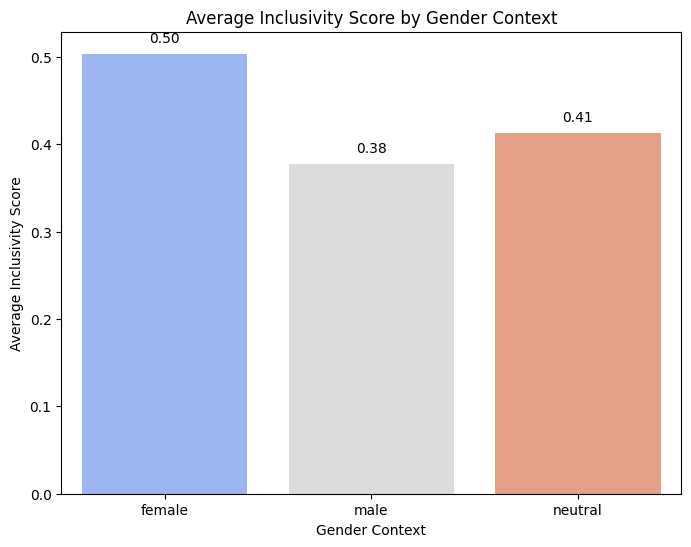

In [ ]:
# Group by 'gender_context' and calculate the mean inclusivity score
avg_incl_score_by_gender = data.groupby('gender_context')['incl_score'].mean().reset_index()

# Display the average inclusivity scores
print(avg_incl_score_by_gender)

# --- Bar Plot for Inclusivity Score by Gender Context ---
plt.figure(figsize=(8, 6))
sns.barplot(x='gender_context', y='incl_score', data=avg_incl_score_by_gender, palette="coolwarm")

# Add plot details
plt.title("Average Inclusivity Score by Gender Context")
plt.xlabel("Gender Context")
plt.ylabel("Average Inclusivity Score")

# Annotate bars with the average values
for i, row in avg_incl_score_by_gender.iterrows():
    plt.text(i, row['incl_score'] + 0.01, f"{row['incl_score']:.2f}", ha='center', va='bottom')

# Display the plot
plt.show()


Now we will split the dataset by gender context and do the semantic analysis on each group.

In [ ]:
# Create subsets for each gender context
female_data = data[data['gender_context'] == 'female']
male_data = data[data['gender_context'] == 'male']
neutral_data = data[data['gender_context'] == 'neutral']
categories = list(custom_categories.keys()) + ['sexist_language']
# Calculate correlations with 'incl_score' for each subset
female_corr = female_data[categories + ['incl_score']].corr()['incl_score'].drop('incl_score')
male_corr = male_data[categories + ['incl_score']].corr()['incl_score'].drop('incl_score')
neutral_corr = neutral_data[categories + ['incl_score']].corr()['incl_score'].drop('incl_score')
correlation_df = pd.DataFrame({
    'Female': female_corr,
    'Male': male_corr,
    'Neutral': neutral_corr
}).reset_index().rename(columns={'index': 'Category'})

In [ ]:
import plotly.express as px

# Assuming female_corr is a pandas Series
female_corr_df = female_corr.reset_index().rename(columns={'index': 'Category', 'incl_score': 'Correlation'})

# Add descriptions for each category
category_descriptions = {
    'professional_roles': 'Jobs such as doctor, lawyer, engineer, and scientist.',
    'stereotypical_roles': 'Traditional roles such as secretary, mistress, and waitress.',
    'physical_descriptors': 'Words describing physical appearance, like beautiful, slender, blond.',
    'emotional_descriptors': 'Words describing emotions, like sensitive, dramatic, and caring.',
    'agency_independence': 'Words reflecting independence of a woman such as confidence, and leadership.',
    'family_roles': 'Family-oriented roles like mother, daughter, and sister.',
    'sexist_language': 'Derogatory or stereotypical terms that reflect sexism.'
}

# Add a 'Description' column to the DataFrame
female_corr_df['Description'] = female_corr_df['Category'].map(category_descriptions)

# Sort the DataFrame by 'Correlation' in ascending order
female_corr_df_sorted = female_corr_df.sort_values(by='Correlation', ascending=True)
# Replace underscores with spaces in the 'Category' column
female_corr_df_sorted['Category'] = female_corr_df_sorted['Category'].str.replace('_', ' ')
# Create a custom gradient based on #ff4f41 (lighter to darker shades)
custom_gradient = [
    (0.0, '#ffe5e2'),  # Very light shade of #ff4f41
    (0.5, '#ff8c75'),  # Medium shade of #ff4f41
    (1.0, '#ff4f41')   # Original #ff4f41
]

# Create the interactive bar plot with the custom gradient
fig = px.bar(
    female_corr_df_sorted,
    x='Category',
    y='Correlation',
    title='Correlation of word categories with inclusivity score (female context)',
    text='Correlation',
    color='Correlation',
    color_continuous_scale=custom_gradient,
    hover_data={'Description': True, 'Correlation': ':.3f', 'Category': False}
)

# Remove the color bar
fig.update_layout(coloraxis_showscale=False)

# Customize the plot layout
fig.update_traces(texttemplate='%{text:.3f}', textposition='outside')
fig.update_layout(
    xaxis_title='Word Category',
    yaxis_title='Correlation with Inclusivity Score',
    xaxis_tickangle=-45,
    height=600,
    plot_bgcolor='rgb(245,245,245)',
    paper_bgcolor='rgb(245,245,245)',
    title=dict(
        x=0.5,
        font=dict(size=20, color='#2c3e50')
    ),
    margin=dict(t=80, b=100, l=60, r=40)
)

# Show the plot
fig.show()
# Save the figure as an HTML file for the website
output_path_7 = figure_path + "correlation_word_categories_inclusivity.html"
fig.write_html(output_path_7)

Keyword Analysis for High-Inclusivity Summaries

Identify specific keywords or phrases that frequently appear in summaries with high inclusivity scores.

In [ ]:
from wordcloud import WordCloud
def preprocess_summary(text):
    doc = nlp(text.lower())
    # Keep specific types of words: adjectives, verbs, and nouns (excluding neutral terms)
    filtered_tokens = [
        token.lemma_
        for token in doc
        if token.pos_ in ['ADJ', 'VERB', 'NOUN']
        and len(token.text) > 2
        and token.text.lower() not in ["new", "good", "old", "young", "real"]  # Exclude neutral terms
    ]
    return filtered_tokens
# Preprocess the text with revised filters

ModuleNotFoundError: No module named 'wordcloud'

In [ ]:
personal_descriptors = [
    "activist", "lawyer", "detective", "doctor", "engineer", "scientist", "professor",
    "journalist", "pilot", "CEO", "politician", "entrepreneur", "architect",
    "judge", "director", "manager", "analyst", "researcher", "investigator",
    "soldier", "technician", "developer", "leader", "executive", "adventurer",
    "mentor", "archaeologist", "girlfriend", "housewife", "mistress", "nanny", "maid",
    "secretary", "damsel", "princess", "cheerleader", "bride", "caretaker",
    "nurse", "singer", "actress", "hostess", "socialite", "beauty queen",
    "waitress", "shop assistant", "dancer", "blond", "brainless", "dumb",
    "chanteuse", "wife", "mother", "daughter", "sister", "grandmother", "aunt", "niece",
    "partner", "fiancée", "widow", "stepmother", "stepdaughter", "mother in law", "sister in law"
]

action_words = [
    "lead", "empower", "inspire", "command", "fight", "defend", "challenge", "conquer", "resist",
    "overcome", "survive", "endure", "protect", "discover", "investigate", "solve", "analyze",
    "invent", "create", "develop", "explore", "rescue", "escape", "pursue", "navigate", "advocate",
    "protest", "campaign", "support", "collaborate", "achieve", "succeed", "triumph", "express",
    "assert", "declare", "confront"
]

emotional_descriptors = [
    "bold", "empathetic", "strong", "vulnerable", "fearless", "independent", "confident", "ambitious",
    "assertive", "determined", "resilient", "courageous", "decisive", "fighter", "survivor", 
    "trailblazer", "pioneer", "rebellious", "outspoken", "resourceful", "adventurous", "empowered",
    "beautiful", "pretty", "gorgeous", "attractive", "slender", "curvy", "petite", "delicate",
    "graceful", "elegant", "youthful", "fair", "blonde", "brunette", "redhead", "voluptuous",
    "angelic", "radiant", "stylish", "fashionable", "charming", "seductive"
]

In [ ]:
# Filter tokens based on custom lists
def filter_custom_terms(tokens):
    return [token for token in tokens if token in personal_descriptors + action_words + emotional_descriptors]

def preprocess_for_wordcloud(text):
    tokens = preprocess_summary(text)
    filtered_tokens = filter_custom_terms(tokens)
    # Remove duplicates by converting to a set and back to a list
    unique_tokens = list(set(filtered_tokens))
    return " ".join(unique_tokens)


In [ ]:
# Apply preprocessing to female data with high inclusivity scores
high_incl_female_data = female_data[female_data['incl_score'] > female_data['incl_score'].median()]
filtered_text = " ".join(high_incl_female_data['clean_summary'].apply(preprocess_for_wordcloud))


# Generate the improved word cloud with the desired artistic direction
wordcloud = WordCloud(
    width=800,
    height=400,
    background_color='white',      # Matching background color
    colormap='Reds',                 # Gradient based on shades of red (#ff4f41)
    max_words=1000,                   # Limit number of words for clarity
    font_path=None                   # Use default font or specify a custom font path if needed
).generate(filtered_text)

# Display the word cloud
plt.figure(figsize=(10, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title("Word Cloud in Female-Led Movies with the Highest Inclusivity", fontsize=10, color='#2c3e50')
plt.show()
# Save the figure as an HTML file for the website
output_path_8 = r"C:\Users\Myriam Charfeddine\Documents\GitHub\SAR-ADA_website\assets\word_cloud.html"
fig.write_html(output_path_8)

Interactive Word Co-occurrence Network

We have decide to create a word co-occurrence network which will help us visualize relationships between frequently occurring words in female-led movie summaries with high inclusivity scores. Each node represents a unique word, and the size of the node is proportional to the number of connections that word has with others. Words that appear together frequently are connected by edges. Hover over each node to see the word and the number of connections, and hover over the edges to see the co-occurrence frequency between word pairs. The network allows you to identify clusters of related words, which can reveal patterns or themes in the text. 

In [ ]:
import networkx as nx
from collections import Counter
from itertools import combinations

# Step 1: Preprocess the Text to Extract Co-occurring Words
def get_cooccurrences(text, window_size=4):
    tokens = text.split()
    cooccurrences = []
    for i in range(len(tokens)):
        window = tokens[i:i + window_size]
        for pair in combinations(window, 2):
            cooccurrences.append(tuple(sorted(pair)))
    return cooccurrences

# Generate co-occurrence pairs from your filtered text
cooccurrences = get_cooccurrences(filtered_text)
cooccurrence_counts = Counter(cooccurrences)

# Filter edges to keep only significant co-occurrences
threshold = 10  # Higher threshold to reduce clutter
filtered_edges = [(word1, word2, count) for (word1, word2), count in cooccurrence_counts.items() if count >= threshold]

# Step 2: Create a Network Graph Using NetworkX
G = nx.Graph()

# Add nodes and edges to the graph
for word1, word2, count in filtered_edges:
    G.add_edge(word1, word2, weight=count)

# Step 3: Adjust Node Size Based on Degree (number of connections)
node_sizes = [G.degree(node)*2 for node in G.nodes()]  # Increased scaling factor for better visibility

# Get positions for the nodes using a spring layout with increased spacing
pos = nx.spring_layout(G, k=1.2, iterations=50)  # k increased to spread out nodes more

# Step 4: Create Plotly Traces for Nodes and Edges
edge_x = []
edge_y = []
edge_text = []

for edge in G.edges(data=True):
    x0, y0 = pos[edge[0]]
    x1, y1 = pos[edge[1]]
    edge_x.extend([x0, x1, None])
    edge_y.extend([y0, y1, None])
    edge_text.append(f"{edge[0]} ↔ {edge[1]}: {edge[2]['weight']}")

edge_trace = go.Scatter(
    x=edge_x, y=edge_y,
    line=dict(width=1, color='rgba(150,150,150,0.4)'),
    hoverinfo='text',
    text=edge_text,
    mode='lines'
)

node_x = []
node_y = []
node_text = []

for node in G.nodes():
    x, y = pos[node]
    node_x.append(x)
    node_y.append(y)
    node_text.append(f"{node}<br>Connections: {G.degree[node]}")

node_trace = go.Scatter(
    x=node_x, y=node_y,
    mode='markers+text',
    text=node_text,
    textposition="top center",
    hoverinfo='text',
    marker=dict(
        color='#ff4f41',
        size=node_sizes,
        
    )
)

# Step 5: Create the Figure and Layout
fig = go.Figure(data=[edge_trace, node_trace],
                layout=go.Layout(
                    title='Interactive word co-occurrence network',
                    title_x=0.5,
                    width=1400,    # Increased figure width
                    height=1000,    # Increased figure height
                    showlegend=False,
                    hovermode='closest',
                    margin=dict(b=0, l=0, r=0, t=50),
                    xaxis=dict(showgrid=False, zeroline=False, showticklabels=False),
                    yaxis=dict(showgrid=False, zeroline=False, showticklabels=False),
                    plot_bgcolor='white'
                ))

fig.show()
output_path_9 = r"C:\Users\Myriam Charfeddine\Documents\GitHub\SAR-ADA_website\assets\word_network.html"
fig.write_html(output_path_9)

## Decision tree


In [7]:
# reimporting just in case

import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor, export_text
from sklearn.metrics import mean_squared_error
from sklearn.tree import plot_tree
import matplotlib.pyplot as plt

In [2]:
data_folder = 'data/preprocessed_datasets/'
all_metrics = pd.read_csv(data_folder+'all_metrics.csv')
all_metrics = all_metrics.dropna(subset=['SuccessMetric'])
all_metrics.head()

,Unnamed: 0,Wiki_ID,Movie_ID,title,BoxOfficeRevenue,Runtime,Languages,Countries,Genres,Year,Net_revenue,rating,SuccessMetric,script_id,imdb_id,female_script,Bechdel_score,proportion_actress,incl_score
0,233,103021,/m/0p_sc,Midnight Express,35000000.0,121.0,"{""/m/064_8sq"": ""French Language"", ""/m/02h40lc""...","{""/m/09c7w0"": ""United States of America"", ""/m/...","{""/m/01jfsb"": ""Thriller"", ""/m/0hn10"": ""LGBT"", ...",1978,32700000.0,7.550000,0.773523,1155,tt0077928,0.052521,0,0.083333,0.045285
1,298,5549065,/m/0ds11z,Sweeney Todd: The Demon Barber of Fleet Street,152523164.0,117.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America"", ""/m/...","{""/m/0lsxr"": ""Crime Fiction"", ""/m/0fx2s"": ""Tra...",2007,102523164.0,7.150000,0.822595,5083,tt0408236,0.359307,1,0.230769,0.307803
2,346,1033297,/m/0401sg,Resident Evil,102441078.0,100.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America"", ""/m/...","{""/m/01jfsb"": ""Thriller"", ""/m/06n90"": ""Science...",2002,69441078.0,6.500000,0.665816,3204,tt0120804,0.394958,3,0.400000,0.598319
3,555,30548208,/m/0g9wdmc,The Iron Lady,114943631.0,104.0,"{""/m/02h40lc"": ""English Language""}","{""/m/0f8l9c"": ""France"", ""/m/07ssc"": ""United Ki...","{""/m/017fp"": ""Biography"", ""/m/07s9rl0"": ""Drama""}",2011,101943631.0,6.300000,0.656896,2634,tt1007029,0.643923,3,0.666667,0.770197
4,562,1964091,/m/069dl1,Next,76066841.0,95.0,"{""/m/064_8sq"": ""French Language"", ""/m/04306rv""...","{""/m/09c7w0"": ""United States of America""}","{""/m/01jfsb"": ""Thriller"", ""/m/06n90"": ""Science...",2007,6066841.0,6.050048,0.400119,1190,tt0435705,0.443932,2,0.166667,0.425755


In [3]:
X2 = all_metrics.drop(columns=["SuccessMetric", "Unnamed: 0", "Wiki_ID", "title", "script_id", "imdb_id", "Movie_ID","rating","Net_revenue","Countries","Languages","Genres","BoxOfficeRevenue","female_script"])
y2 = all_metrics["SuccessMetric"]

#X2 = pd.get_dummies(X2, columns=["Languages", "Countries", "Genres"], drop_first=True) #tried but was not conclusive due to too many 'categories'

X2_train, X2_test, y2_train, y2_test = train_test_split(X2, y2, test_size=0.2, random_state=42)

model2 = DecisionTreeRegressor(max_depth=5, random_state=42)

model2.fit(X2_train, y2_train)

DecisionTreeRegressor(max_depth=5, random_state=42)

In [4]:
y2_pred = model2.predict(X2_test)

mse = mean_squared_error(y2_test, y2_pred)
print(f"Mean Squared Error: {mse}")

Mean Squared Error: 0.04562580580237783


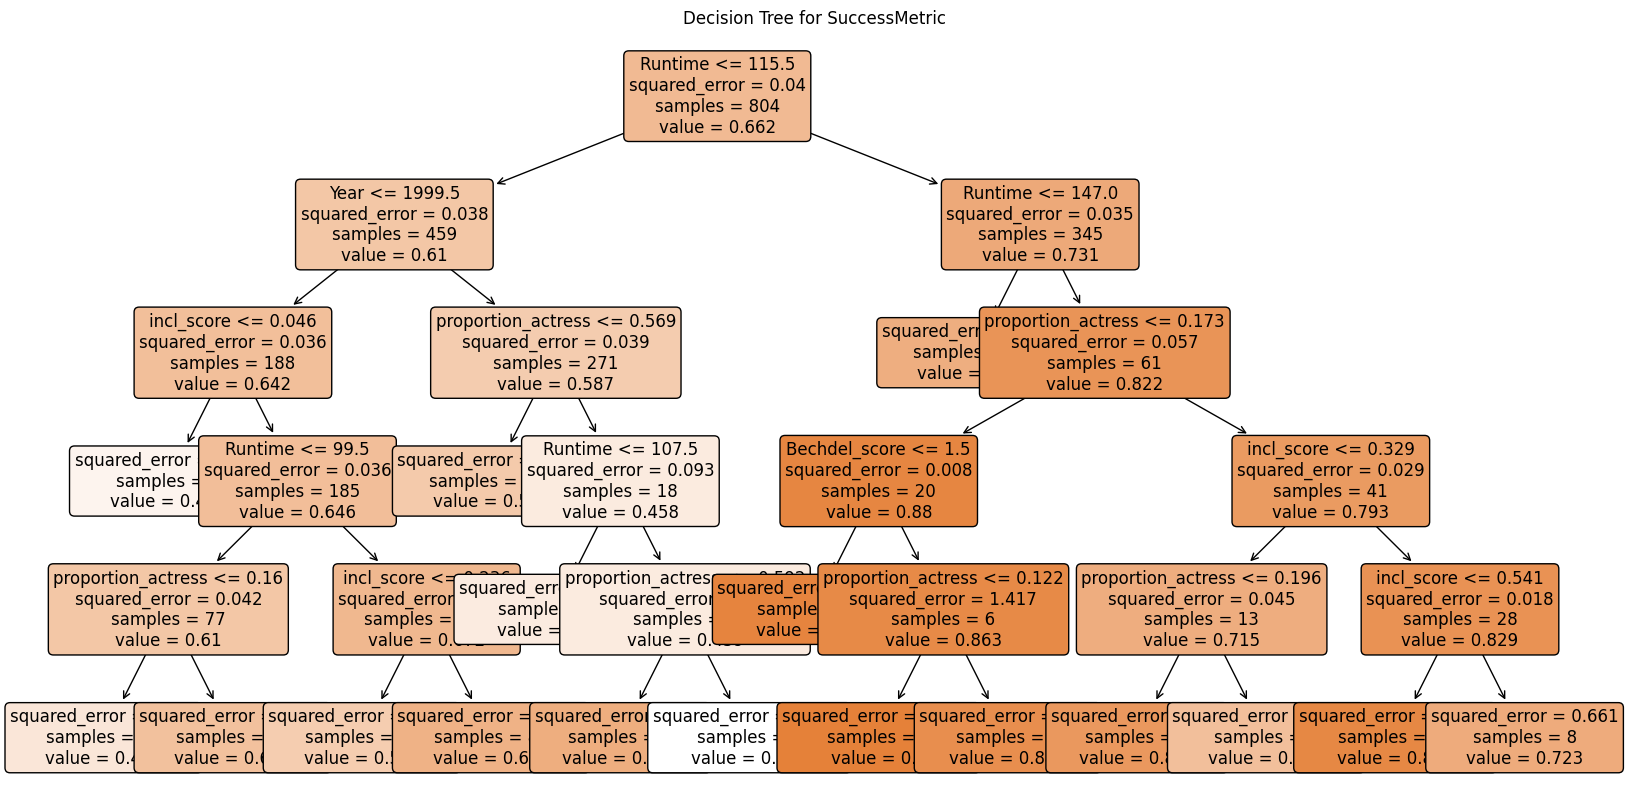

In [5]:
plt.figure(figsize=(20, 10))
plot_tree(
    model2,
    feature_names=list(X2.columns),
    filled=True,
    rounded=True,
    fontsize=12
)
plt.title("Decision Tree for SuccessMetric")
plt.show()

Transposing an iteration of the decision tree into a sankey diagram for more visibility and esthetic

In [6]:
import plotly.graph_objects as go


labels = [
    "Runtime <= 115.5\n(Score = 0.657)",         
    "proportion_actress <= 0.577\n(Score = 0.604)",           
    "Year <= 2010.5\n(Score = 0.488)",                
    "incl_score <= 0.631\n(Score = 0.511)",           
    "Runtime > 115.5\n(Score = 0.732)",               
    "Runtime <= 151.5\n(Score = 0.712)",              
    "proportion_actress <= 0.173\n(Score = 0.833)",            
    "incl_score <= 0.337\n(Score = 0.803)",           
    "Bechdel_score <= 1.5\n(Score = 0.891)",          
    "Bechdel_score <= 2.5\n(Score = 0.879)",          
    "incl_score <= 0.57\n(Score = 0.852)",            
]

# values of success score 
customdata = [
    0.657, 0.604, 0.488, 0.511, 0.732, 0.712, 0.833, 0.803, 0.891, 0.879, 0.852
]

# links between nodes
sources = [
    0, 0,         
    1, 1,         
    2, 2,        
    3, 3,         
    4, 4,        
    5, 5,        
    6, 6,         
    7, 7,         
    8, 8,         
    9, 9,         
    10, 10        
]

targets = [
    1, 4,         
    2, 5,         
    3, 6,         
    6, 7,         
    7, 8,         
    8, 9,        
    9, 10,     
    10, 3       
]
# Sample counts 

values = [
    804, 473,     
    447, 331,     
    276, 55,     
    36, 19,      
    19, 7,       
    7, 4,         
    4, 23,        
    23, 4         
]

fig = go.Figure(data=[go.Sankey(
    node=dict(
        pad=15,
        thickness=20,
        line=dict(color="black", width=0.5),
        label=labels,
        customdata=customdata,
        hovertemplate='Node: %{label}<br>Success Metric: %{customdata:.3f}<extra></extra>',  
        color="lightblue"  
    ),
    link=dict(
        source=sources,
        target=targets,
        value=values,
        color="rgba(192, 192, 192, 0.4)"   
    )
)])

fig.update_layout(
    title_text="Sankey Diagram of the Success Metric",
    font_size=12
)

fig.show()